In [2]:
!pip install skimpy
!pip install pyforest
from skimpy import skim

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
jupyterlab 4.1.6 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is i

In [106]:
%%time
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

CPU times: user 974 µs, sys: 0 ns, total: 974 µs
Wall time: 988 µs


## Plan : 
- 1. EDA
    - Features (type, signification, coherence avec le dtypes, etc.)
- 2. Imputation des données
    - Stratégie pour les données manquantes
    - Présence de valeurs aberrantes ?
- 3. Feature Engineering
    - Création de nouvelles features 
- 4.  Data visualisation
    - Analyse univariée
    - Analyse bivariée
- 5. PCA et clusterisation
    

# 1. EDA

## People
- **ID** : id du client
- **Year_Birth** : date d'anniversaire du client
- **Education** : niveau d'étude du client
- **Marital_Status** : statut marital du client
- **Income** : revenue annuel du client
- **Kidhome** : nombre d'enfant à la maison
- **Teenhome** : nombre d'adolescent à la maison
- **Dt_Customer** : Date of customer's enrollment with the company
- **Recency** : date du dernier achat du client
- **Complain** : 1 if the customer complained in the last 2 years, 0 otherwise
## Products
- **MntWines** : Total des dépenses dans le vin ces deux dernières années
- **MntFruits** : total des dépenses dans les fruits ces deux dernieres années
- **MntMeatProducts** : total des dépenses dans la viande ces deux dernieres années
- **MntFishProducts** : total des dépenses dans le poisson ces deux dernieres années
- **MntSweetProducts** : Amount spent on sweets in last 2 years
- **MntGoldProds** : Amount spent on gold in last 2 years
## Promotion
- **NumDealsPurchases** : Number of purchases made with a discount
- **AcceptedCmp1** : 1 if customer accepted 1st campaign offer, 0 otherwise
- **AcceptedCmp2** : 1 if customer accepted 2nd campaign offer, 0 otherwise
- **AcceptedCmp3** : 1 if customer accepted 3rd campaign offer, 0 otherwise
- **AcceptedCmp4** : 1 if customer accepted 4th campaign offer, 0 otherwise
- **AcceptedCmp5** : 1 if customer accepted 5th campaign offer, 0 otherwise
- **Response** : 1 if customer accepted the offer in the last campaign, 0 otherwise
## Place
- **NumWebPurchases** : Number of purchases made through the company’s website
- **NumCatalogPurchases** : Number of purchases made using a catalogue
- **NumStorePurchases** : Number of purchases made directly in stores
- **NumWebVisitsMonth** : Number of visits to company’s website in the last month

Regardons un résumé des données  :

In [4]:
data = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep = "\t")
df = data.copy()

In [5]:
pd.set_option('display.max_columns', None)
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

In [6]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 2240   │ │ int64       │ 25    │                                                          │
│ │ Number of columns │ 29     │ │ string      │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA  ┃ NA %  ┃ mean      ┃ sd      ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ ID                    │   0 │     0 │      5592 │    3247 │    0 │  2828 │  5458 │  8428 │  11190 │ ▇▇▇▇▆▇ │  │
│ │ Year_Birth            │   0 │     0 │      1969 │   11.98 │ 1893 │  1959 │  1970 │  1977 │   1996 │    ▅▇▃ │  │
│ │ Income                │  24 │  1.07 │     52250 │   25170 │ 1730 │ 35300 │ 51380 │ 68520 │ 666700 │   ▇    │  │
│ │ Kidhome               │   0 │     0 │    0.4442 │  0.5384 │    0 │     0 │     0 │     1 │      2 │  ▇  ▆  │  │
│ │ Teenhome              │   0 │     0 │    0.5062 │  0.5445 │    0 │     0 │     0 │     1 │      2 │  ▇  ▇  │  │
│ │ Recency               │   0 │     0 │     49.11 │   28.96 │    0 │    24 │    49 │    74 │     99 │ ▇▇▇▇▇▇ │  │
│ │ MntWines              │   0 │     0 │     303.9 │   336.6 │    0 │ 23.75 │ 173.5 │ 504.2 │   1493 │ ▇▂▂▁▁  │  │
│ │ MntFruits             │   0 │     0 │      26.3 │   39.77 │    0 │     1 │     8 │    33 │    199 │  ▇▁▁   │  │
│ │ MntMeatProducts       │   0 │     0 │     166.9 │   225.7 │    0 │    16 │    67 │   232 │   1725 │  ▇▁▁   │  │
│ │ MntFishProducts       │   0 │     0 │     37.53 │   54.63 │    0 │     3 │    12 │    50 │    259 │  ▇▁▁   │  │
│ │ MntSweetProducts      │   0 │     0 │     27.06 │   41.28 │    0 │     1 │     8 │    33 │    263 │  ▇▁▁   │  │
│ │ MntGoldProds          │   0 │     0 │     44.02 │   52.17 │    0 │     9 │    24 │    56 │    362 │  ▇▁▁   │  │
│ │ NumDealsPurchases     │   0 │     0 │     2.325 │   1.932 │    0 │     1 │     2 │     3 │     15 │  ▇▃▁   │  │
│ │ NumWebPurchases       │   0 │     0 │     4.085 │   2.779 │    0 │     2 │     4 │     6 │     27 │  ▇▃▁   │  │
│ │ NumCatalogPurchases   │   0 │     0 │     2.662 │   2.923 │    0 │     0 │     2 │     4 │     28 │   ▇▂   │  │
│ │ NumStorePurchases     │   0 │     0 │      5.79 │   3.251 │    0 │     3 │     5 │     8 │     13 │ ▂▇▃▃▂▃ │  │
│ │ NumWebVisitsMonth     │   0 │     0 │     5.317 │   2.427 │    0 │     3 │     6 │     7 │     20 │  ▅▇▇   │  │
│ │ AcceptedCmp3          │   0 │     0 │   0.07277 │  0.2598 │    0 │     0 │     0 │     0 │      1 │ ▇    ▁ │  │
│ │ AcceptedCmp4          │   0 │     0 │   0.07455 │  0.2627 │    0 │     0 │     0 │     0 │      1 │ ▇    ▁ │  │
│ │ AcceptedCmp5          │   0 │     0 │   0.07277 │  0.2598 │    0 │     0 │     0 │     0 │      1 │ ▇    ▁ │  │
│ │ AcceptedCmp1          │   0 │     0 │   0.06429 │  0.2453 │    0 │     0 │     0 │     0 │      1 │ ▇    ▁ │  │
│ │ AcceptedCmp2          │   0 │     0 │   0.01339 │   

In [7]:
#Regardons si des variables prennent une seule modalité
[f'{col:-<20} :  {df[col].unique()[:3]}  ({df[col].nunique()} values)' for col in df if df[col].nunique()<=1]

['Z_CostContact------- :  [3]  (1 values)',
 'Z_Revenue----------- :  [11]  (1 values)']

Nous pouvons supprimer ces features étant donnée qu'elles n'apportent aucune information car il n'y a pas de variabilité

In [8]:
no_var_col = [i for i in df if df[i].nunique()<=1]
identifiant = df["ID"]
df = df.drop(no_var_col, axis = 1)
# df = df.drop("ID", axis = 1)

Convertissons les colonnes avec le bon dtypes

In [9]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
dtype: object

Regardons les colonnes object  dans un premier temps :

In [10]:
df.select_dtypes("object").head()

Education Marital_Status Dt_Customer
0  Graduation         Single  04-09-2012
1  Graduation         Single  08-03-2014
2  Graduation       Together  21-08-2013
3  Graduation       Together  10-02-2014
4         PhD        Married  19-01-2014

Nous avons 2 colonnes **category** et 1 colonne **date**
- Traitement des colonnes category :

In [11]:
for col in df.select_dtypes("object"):
    if col != 'Dt_Customer':
        df[col] = df[col].astype('category')

Traitement de la colonne de type date :

In [12]:
df.select_dtypes("object").columns

Index(['Dt_Customer'], dtype='object')

In [13]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format ='%d-%m-%Y')

regardons si des colonnes  prennent 2 modalités, dans ce cas on les transformera en **booleeen**

In [14]:
[f'{col:-<20} :  {df[col].unique()[:3]}  ({df[col].nunique()} values)' for col in df if df[col].nunique()==2]

['AcceptedCmp3-------- :  [0 1]  (2 values)',
 'AcceptedCmp4-------- :  [0 1]  (2 values)',
 'AcceptedCmp5-------- :  [0 1]  (2 values)',
 'AcceptedCmp1-------- :  [0 1]  (2 values)',
 'AcceptedCmp2-------- :  [0 1]  (2 values)',
 'Complain------------ :  [0 1]  (2 values)',
 'Response------------ :  [1 0]  (2 values)']

In [15]:
boolean_cols = [col for col in df if df[col].nunique()==2]

In [16]:
for col in boolean_cols:
    df[col]= df[col].astype("boolean")

In [17]:
df.dtypes.sort_index()
#les catégories ont bien été changées

AcceptedCmp1                  boolean
AcceptedCmp2                  boolean
AcceptedCmp3                  boolean
AcceptedCmp4                  boolean
AcceptedCmp5                  boolean
Complain                      boolean
Dt_Customer            datetime64[ns]
Education                    category
ID                              int64
Income                        float64
Kidhome                         int64
Marital_Status               category
MntFishProducts                 int64
MntFruits                       int64
MntGoldProds                    int64
MntMeatProducts                 int64
MntSweetProducts                int64
MntWines                        int64
NumCatalogPurchases             int64
NumDealsPurchases               int64
NumStorePurchases               int64
NumWebPurchases                 int64
NumWebVisitsMonth               int64
Recency                         int64
Response                      boolean
Teenhome                        int64
Year_Birth  

### Bilan :
- Dimensions (29,2240)
- 25 int, 1 float, 3 object
- Données manquantes pour la colonne income 
- Suppression des colonnes n'apportant aucunes variabilité
- colonnes avec bon dtypes

## 2. Imputation des données

- Pour les NaN :
    - Il n'y a qu'une seule colonne qui contient des données manquantes : income (le revenu), c'est une colonne qui renseigne sur une données assez importante, regardons les lignes pour lesquelles le revenu n'est pas présent
    
#### Observons la distribution dans un premier temps

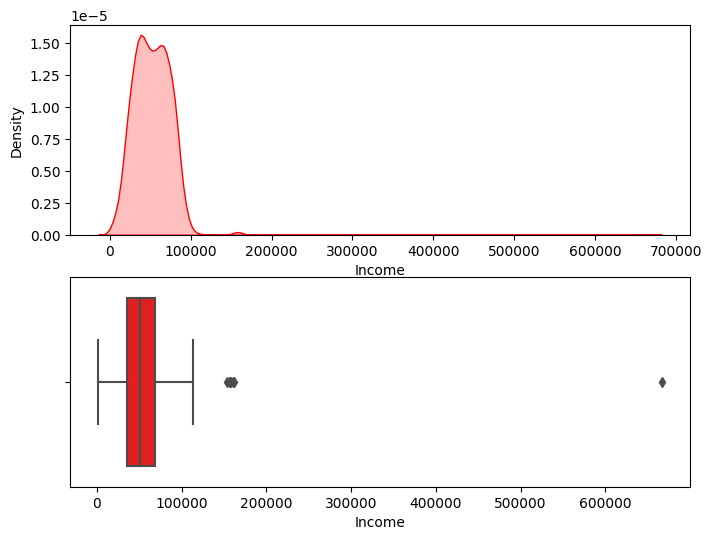

In [18]:
fig,axes = plt.subplots(2,1, figsize=(8,6))
ax = sns.kdeplot(data = df, x ='Income',
            fill = True, color = "red", ax=axes[0])

ax = sns.boxplot(data = df,x = "Income",
             color = "red", ax=axes[1])

plt.show()


On peut voir qu'il y a quelques outliers, dont une valeur qui est très élevée

In [19]:
def outliers(col):
    "renvoi un booleen qui indique si l'observation est un outlier ou non pour une colonne donnée"
    q1=df[col].quantile(q=0.25)
    q3=df[col].quantile(q=1-0.25)
    iqr = q3-q1
    borne_inf = q1-(1.5*iqr)
    borne_sup = q3+(1.5*iqr)
    return (df[col]<=borne_inf) | (df[col]>=borne_sup)
    

In [20]:
outliers("Income").value_counts()

Income
False    2232
True        8
Name: count, dtype: int64

Présence de 8 lignes avec des outliers, regardons de plus près :

In [21]:
df[outliers("Income")]
# on peut voir que les salaires sont très élevées, surtout pour le salaire = 666666.0 qui semble très élevé par rapport aux autres

ID  Year_Birth   Education Marital_Status    Income  Kidhome  \
164    8475        1973         PhD        Married  157243.0        0   
617    1503        1976         PhD       Together  162397.0        1   
655    5555        1975  Graduation       Divorced  153924.0        0   
687    1501        1982         PhD        Married  160803.0        0   
1300   5336        1971      Master       Together  157733.0        1   
1653   4931        1977  Graduation       Together  157146.0        0   
2132  11181        1949         PhD        Married  156924.0        0   
2233   9432        1977  Graduation       Together  666666.0        1   

      Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
164          1  2014-03-01       98        20          2             1582   
617          1  2013-06-03       31        85          1               16   
655          0  2014-02-07       81         1          1                1   
687          0  2012-08-04       21        55         16             1622   
1300         0  2013-06-04       37        39          1                9   
1653         0  2013-04-29       13         1          0             1725   
2132         0  2013-08-29       85         2          1                2   
2233         0  2013-06-02       23         9         14               18   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
164                 1                 2             1                 15   
617                 2                 1             2                  0   
655                 1                 1             1                  0   
687                17                 3             4                 15   
1300                2                 0             8                  0   
1653                2                 1             1                  0   
2132                1                 1             1                  0   
2233                8                 1            12                  4   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
164                 0                   22                  0   
617                 0                    0                  1   
655                 0                    0                  0   
687                 0                   28                  1   
1300                1                    0                  1   
1653                0                   28                  0   
2132                0                    0                  0   
2233                3                    1                  3   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
164                   0         False         False         False   
617                   1         False         False         False   
655                   0         False         False         False   
687                   0         False         False         False   
1300                  1         False         False         False   
1653                  1         False         False         False   
2132                  0         False         False         False   
2233                  6         False         False         False   

      AcceptedCmp1  AcceptedCmp2  Complain  Response  
164          False         False     False     False  
617          False         False     False     False  
655          False         False     False     False  
687          False         False     False     False  
1300         False         False     False     False  
1653         False         False     False     False  
2132         False         False     False     False  
2233         False         False     False     False

##### Supprimons ces observations

In [22]:
#récupération de l'index :
outliers_line = df[df['Income']>200000].index
outliers_line

Index([2233], dtype='int64')

In [23]:
df = df.drop(index = outliers_line, axis = "0")

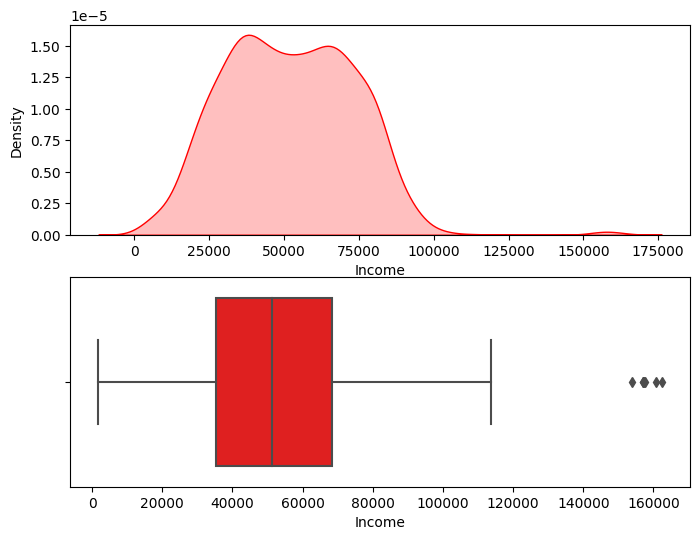

In [24]:
fig,axes = plt.subplots(2,1, figsize=(8,6))
ax = sns.kdeplot(data = df, x ='Income',
            fill = True, color = "red", ax=axes[0])

ax = sns.boxplot(data = df,x = "Income",
             color = "red", ax=axes[1])

plt.show()


- Les visualisations sont beaucoups plus lisses et lisible.
- Maintenant, nous allons nous occuper des données, manquantes, et plutôt que de supprimer les lignes, nous allons plutôt les remplacés par la **moyenne** (car nous venons de supprimer les outliers, donc pas besoin d'utiliser la médiane)
- Pour cela, nous n'allons pas utiliser la moyenne globale, mais plutôt la moyenne en fonction du niveau d'étude de la personne, ainsi, nous aurons des moyenne salariales un peu plus fidèle

In [25]:
print("Salaire moyen en fonction du niveau d'étude :")
pd.pivot_table(data = df[["Income","Education"]], columns = "Education", observed = True, aggfunc="mean")

Salaire moyen en fonction du niveau d'étude :


Education  2n Cycle         Basic    Graduation        Master           PhD
Income     47633.19  20306.259259  52169.749776  52917.534247  56145.313929

In [26]:
#lignes avec les données manquantes : 
df.loc[df["Income"].isnull(), ["Income","Education"]].head()

Income   Education
10     NaN  Graduation
27     NaN  Graduation
43     NaN         PhD
48     NaN  Graduation
58     NaN  Graduation

In [27]:
#récupérons les index
index_null = df.loc[df["Income"].isnull(), ["Income","Education"]].index

In [28]:
# Imputons les données manquantes :
df['Income'] = df.groupby('Education')['Income'].transform(lambda x: x.fillna(x.mean())) 
#On remplace les valeurs manquantes dans la colonne "Income" par la moyenne de cette colonne calculée pour
#chaque groupe de données défini par les valeurs uniques de la colonne "Education".

In [29]:
#regardons si les nouvelles données imputées concordent :
df.loc[index_null, ["Income","Education"]].head()
#L'imputation a été correctement effectuée

Income   Education
10  52169.749776  Graduation
27  52169.749776  Graduation
43  56145.313929         PhD
48  52169.749776  Graduation
58  52169.749776  Graduation

## 3. Feature engineering
- Observons les features que nous disposons

In [30]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   
3  2014-02-10       26        11          4               20               10   
4  2014-01-19       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7         False   
1                    1                  2                  5         False   
2                    2                 10                  4         False   
3                    0                  4                  6         False   
4                    3                  6                  5         False   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
0         False         False         False         False     False      True  
1         False         False         False         False     False     False  
2         False         False         False         False     False     False  
3         False         False         False         False     False     False  
4         False         False         False         False     False     False

Nous pouvons créé plusieurs nouvelles features : 
- Age : A partir de la colonne Year_Birth en soustrayant la date de création de ce dataframe (2021)
- Adulthome : A partir de la colonne Martial_Status on peut déduire s'il y a 1 ou 2 adulte (en couple ou seul)
- Totalhome : Nombre total d'individus par maison (en additionnant les colonnes Kidhome,Teenhome et Adulthome)
- Totalproduct : C'est le total dépensé, cela correspond à la somme de tous les produits dépensé pour chaque observation
- Yearmembership :  Correspond au nombre d'année que l'individu est client (différence entre aujourd'hui et la date du premier achat du client)

In [31]:
#Age :
df['Age'] = df.Year_Birth.apply(lambda x : 2021 - x) #Année 2021 car le jeu de donnée provient de cette date

In [32]:
#Adulthome
df.Marital_Status.unique()
# 8 catégories, 2 indique qu'il y a deux parents et le reste sous entend qu'il n'y a qu'un seul parent

['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone', 'Absurd', 'YOLO']
Categories (8, object): ['Absurd', 'Alone', 'Divorced', 'Married', 'Single', 'Together', 'Widow', 'YOLO']

In [33]:
def adulte_home(x):
    if x in ['Together', 'Married']:
        return 2
    else:
        return 1

In [34]:
df["Adulthome"] = df.Marital_Status.map(adulte_home)

In [35]:
#Totalhome : 
#Récupération des colonnes indiquant le nombre d'enfant, d'adolescent ou d'adulte dans un foyer :
total_home = [i for i in df if i[-4:]=="home"]
total_home

['Kidhome', 'Teenhome', 'Adulthome']

In [36]:
#Somme en ligne des individus de chaque age afin d'obtenir le total : 
df['Totalhome'] = df[total_home].sum(axis = 1)

In [37]:
#Totalproduct :
# même raisonnement que pour les individus dans un foyer, ici ce sont les colonnes commençant par "Mnt":
total_product = [i for i in df if i[:3]=="Mnt"]
total_product

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds']

In [38]:
df['Totalproduct'] = df[total_product].sum(axis = 1)

In [39]:
#Yearmembership
#d'abord nous allons récupérer la date d'achat la plus ancienne par identifiant client :
min_achat = df.groupby("ID")["Dt_Customer"].min().reset_index()
min_achat.head()

ID Dt_Customer
0   0  2013-05-04
1   1  2014-06-15
2   9  2012-08-18
3  13  2013-07-22
4  17  2013-09-06

In [40]:
#Ensuite, on va créé la colonne Yearmembership qui est le résultat de l'extraction de l'année de la date
#d'achat la plus ancienne et la soustraire à l'année du dataframe (donc toujours 2021) :
min_achat["Yearmembership"] = min_achat['Dt_Customer'].dt.year.apply(lambda x : 2021 - x)
min_achat.head()

ID Dt_Customer  Yearmembership
0   0  2013-05-04               8
1   1  2014-06-15               7
2   9  2012-08-18               9
3  13  2013-07-22               8
4  17  2013-09-06               8

In [41]:
#enfin on peut merge ce dataframe temporaire à notre dataframe en gardant uniquement les colonnes ID et Yearmembership :
min_achat = min_achat.drop("Dt_Customer", axis = 1)
df = pd.merge(left = df, right = min_achat , on = "ID", how = "inner")

##### Regardons notre dataframe après toutes les étapes de cleaning : 

In [42]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   
3  2014-02-10       26        11          4               20               10   
4  2014-01-19       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7         False   
1                    1                  2                  5         False   
2                    2                 10                  4         False   
3                    0                  4                  6         False   
4                    3                  6                  5         False   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0         False         False         False         False     False      True   
1         False         False         False         False     False     False   
2         False         False         False         False     False     False   
3         False         False         False         False     False     False   
4         False         False         False         False     False     False   

   Age  Adulthome  Totalhome  Totalproduct  Yearmembership  
0   64          1          1          1617               9  
1   67          1          3            27               7  
2   56          2          2           776               8  
3   37          2          3            53               7  
4   40          2          3           422               7

Les 5 dernières colonnes correspondent à nos nouvelles données pour lesquelles nous avons effectuer le feature engineering 

## 4. Data visualisation
### Analyse univariée
- Séparons les variables catégoriques/discrètes des variables quantitatives continues


In [43]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 2239   │ │ int64       │ 21    │ │ Education             │                                │
│ │ Number of columns │ 32     │ │ bool        │ 7     │ │ Marital_Status        │                                │
│ └───────────────────┴────────┘ │ category    │ 2     │ └───────────────────────┘                                │
│                                │ float64     │ 1     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0    ┃ p25    ┃ p50   ┃ p75   ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ ID                    │   0 │     0 │    5590 │    3246 │     0 │   2828 │  5455 │  8424 │  11190 │ ▇▇▇▇▆▇ │  │
│ │ Year_Birth            │   0 │     0 │    1969 │   11.99 │  1893 │   1959 │  1970 │  1977 │   1996 │    ▅▇▃ │  │
│ │ Income                │   0 │     0 │   51980 │   21410 │  1730 │  35530 │ 51570 │ 68280 │ 162400 │  ▃▇▇▁  │  │
│ │ Kidhome               │   0 │     0 │  0.4439 │  0.5384 │     0 │      0 │     0 │     1 │      2 │  ▇  ▆  │  │
│ │ Teenhome              │   0 │     0 │  0.5065 │  0.5446 │     0 │      0 │     0 │     1 │      2 │  ▇  ▇  │  │
│ │ Recency               │   0 │     0 │   49.12 │   28.96 │     0 │     24 │    49 │    74 │     99 │ ▇▇▇▇▇▇ │  │
│ │ MntWines              │   0 │     0 │   304.1 │   336.6 │     0 │     24 │   174 │ 504.5 │   1493 │ ▇▂▂▁▁  │  │
│ │ MntFruits             │   0 │     0 │   26.31 │   39.78 │     0 │      1 │     8 │    33 │    199 │  ▇▁▁   │  │
│ │ MntMeatProducts       │   0 │     0 │     167 │   225.7 │     0 │     16 │    67 │   232 │   1725 │  ▇▁▁   │  │
│ │ MntFishProducts       │   0 │     0 │   37.54 │   54.64 │     0 │      3 │    12 │    50 │    259 │  ▇▁▁   │  │
│ │ MntSweetProducts      │   0 │     0 │   27.07 │   41.29 │     0 │      1 │     8 │    33 │    263 │  ▇▁▁   │  │
│ │ MntGoldProds          │   0 │     0 │   44.04 │   52.17 │     0 │      9 │    24 │    56 │    362 │  ▇▁▁   │  │
│ │ NumDealsPurchases     │   0 │     0 │   2.324 │   1.932 │     0 │      1 │     2 │     3 │     15 │  ▇▃▁   │  │
│ │ NumWebPurchases       │   0 │     0 │   4.085 │   2.779 │     0 │      2 │     4 │     6 │     27 │  ▇▃▁   │  │
│ │ NumCatalogPurchases   │   0 │     0 │   2.663 │   2.924 │     0 │      0 │     2 │     4 │     28 │   ▇▂   │  │
│ │ NumStorePurchases     │   0 │     0 │   5.791 │   3.251 │     0 │      3 │     5 │     8 │     13 │ ▂▇▃▃▂▃ │  │
│ │ NumWebVisitsMonth     │   0 │     0 │   5.316 │   2.427 │     0 │      3 │     6 │     7 │     20 │  ▅▇▇   │  │
│ │ Age                   │   0 │     0 │    52.2 │   11.99 │    25 │     44 │    51 │    62 │    128 │  ▃▇▅   │  │
│ │ Adulthome             │   0 │     0 │   1.644 │  0.4788 │     1 │      1 │     2 │     2 │      2 │ ▅    ▇ │  │
│ │ Totalhome             │   0 │     0 │   2.595 │  0.9

In [44]:
var_num = [col for col in df.select_dtypes(["int","float"]) if col != "ID"]
var_qual = [col for col in df.select_dtypes(["category","bool"]) ]
var_time = [col for col in df if col  not in var_num + var_qual and col != "ID"]
print("variables numérique :\n" , var_num)
print()
print("variables qualitatives :\n" , var_qual)
print()
print("variables temporelle :\n" , var_time)
print()

print("Somme des trois :", len(var_num+var_qual+var_time))

variables numérique :
 ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Adulthome', 'Totalhome', 'Totalproduct', 'Yearmembership']

variables qualitatives :
 ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']

variables temporelle :
 ['Dt_Customer']

Somme des trois : 31


Nous avons récupéré l'ensemble des colonnes excepté l'id qui a été volontairement omis

#### analyse des Variables numériques : 

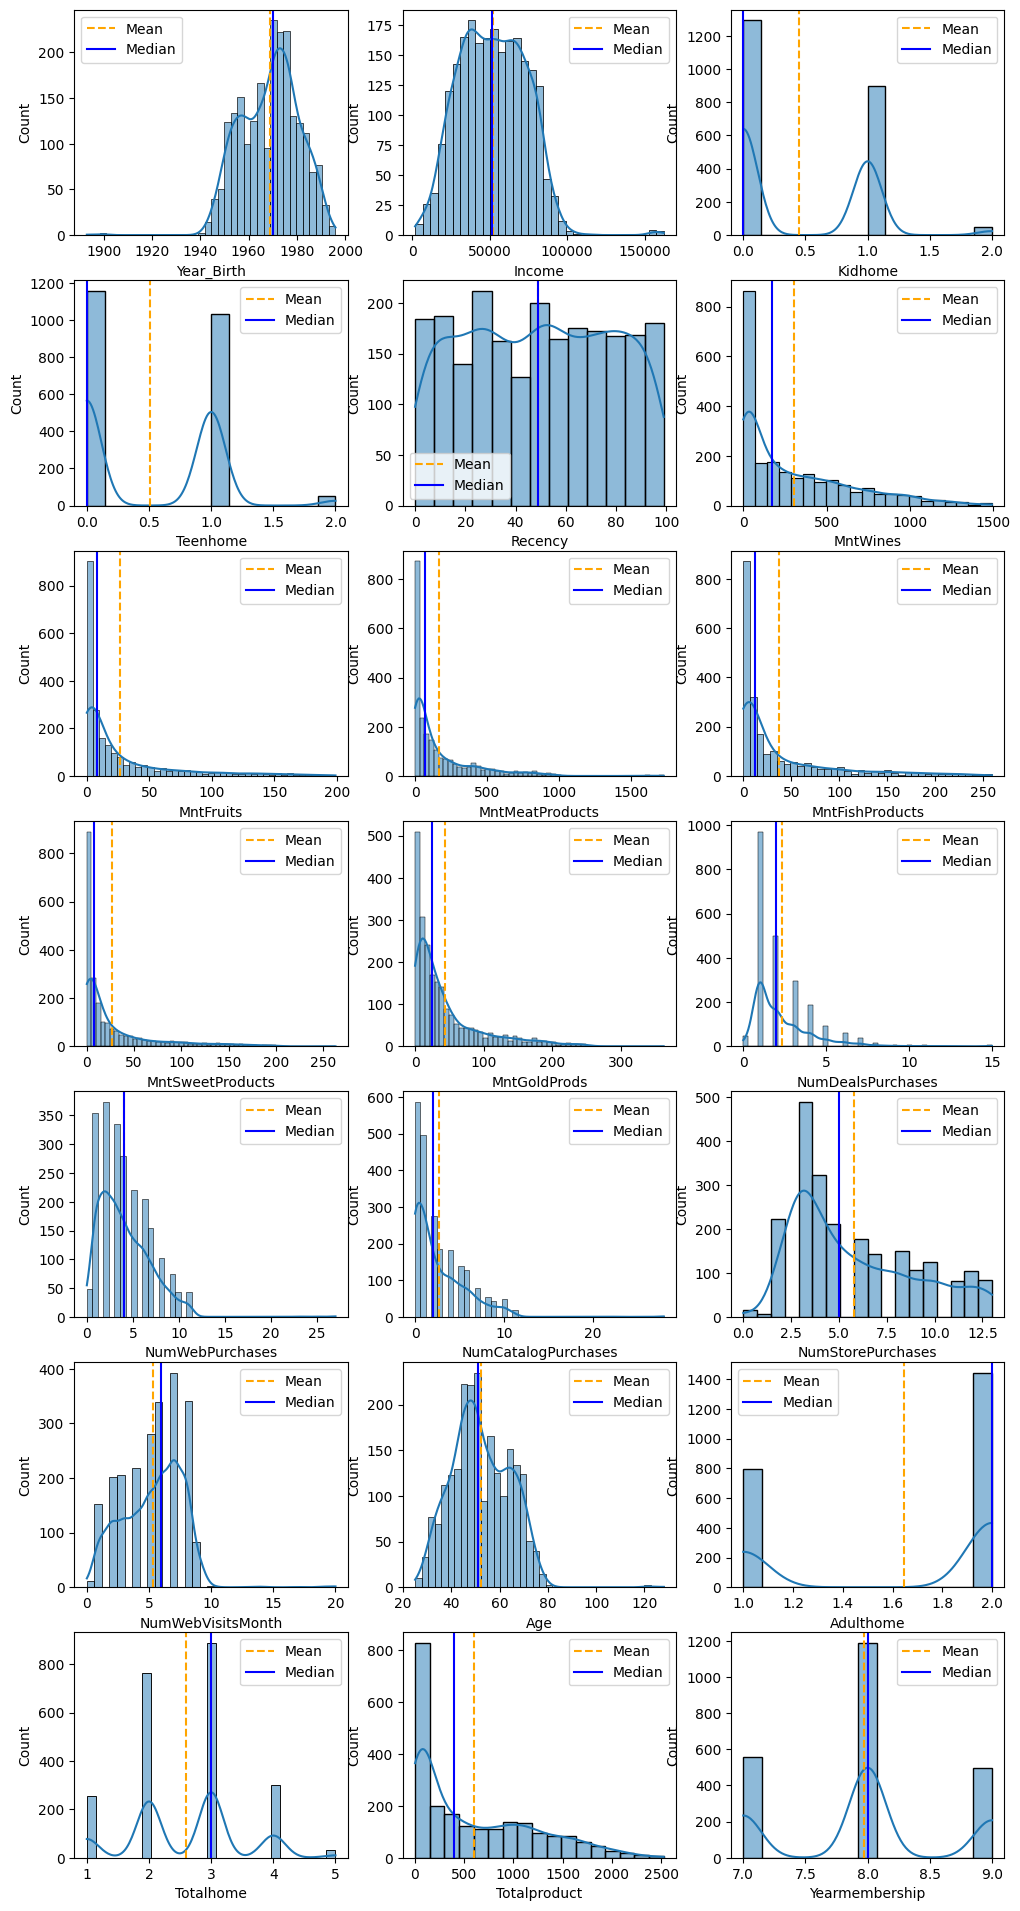

In [45]:
fig, axes = plt.subplots(7,3,figsize=(12,24))
for i,k in enumerate(var_num):
    nrow, ncol = i//3, i%3
    ax = sns.histplot(data = df, x = k, ax = axes[nrow,ncol], kde = True)
    ax.axvline(df[k].mean(), label = "Mean", ls= "--", color = "orange")
    ax.axvline(df[k].median(), label = "Median", ls= "-", color = "blue")
    ax.legend()
plt.show()

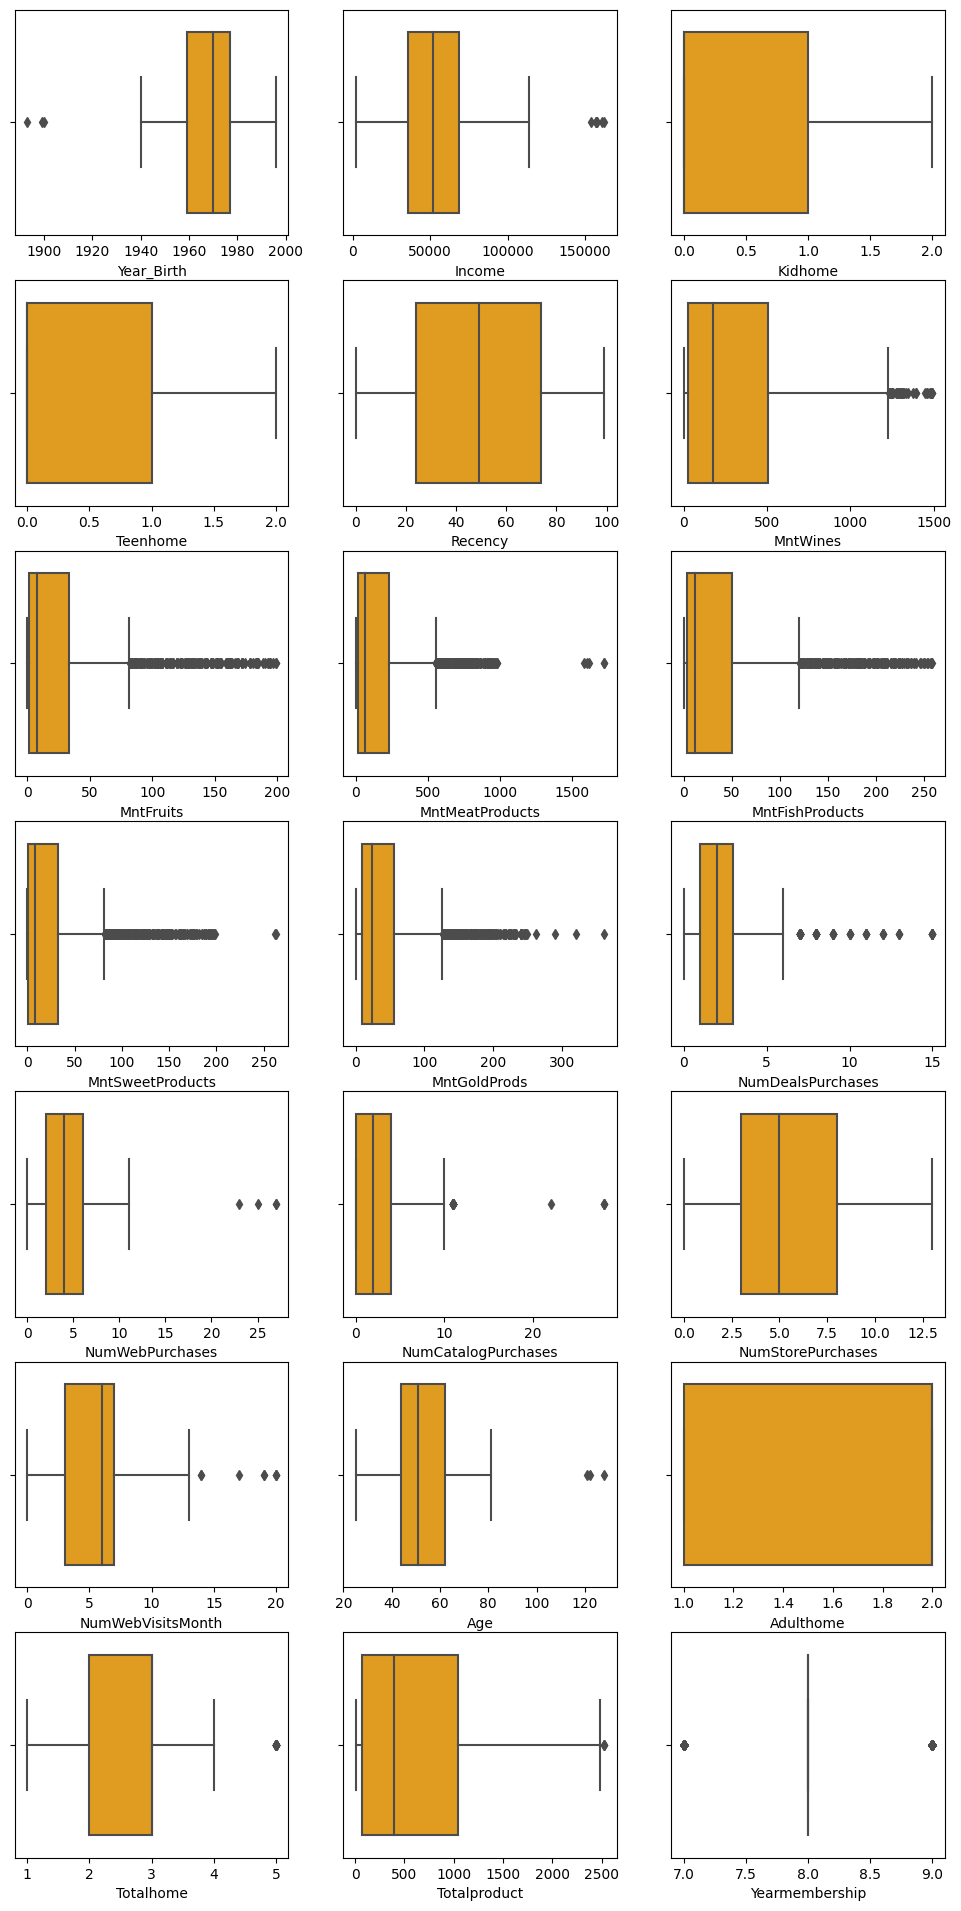

In [46]:
fig, axes = plt.subplots(7,3,figsize=(12,24))
for i,k in enumerate(var_num):
    nrow, ncol = i//3, i%3
    ax = sns.boxplot(data = df,x = k,
             color = "orange", ax=axes[nrow,ncol])
plt.show()

on observe quelques valeurs qui semblent aberrantes surtout pour la variable Year_Birth avec des dates d'anniversaire < 1920 que l'on va retirer

In [47]:
df[(df["Year_Birth"]<1920)] # 3 personnnes a retirer

ID  Year_Birth Education Marital_Status   Income  Kidhome  Teenhome  \
192   7829        1900  2n Cycle       Divorced  36640.0        1         0   
239  11004        1893  2n Cycle         Single  60182.0        0         1   
339   1150        1899       PhD       Together  83532.0        0         0   

    Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
192  2013-09-26       99        15          6                8   
239  2014-05-17       23         8          0                5   
339  2013-09-26       36       755        144              562   

     MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
192                7                 4            25                  1   
239                7                 0             2                  1   
339              104                64           224                  1   

     NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
192                2                    1                  2   
239                1                    0                  2   
339                4                    6                  4   

     NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
192                  5         False         False         False   
239                  4         False         False         False   
339                  1         False         False          True   

     AcceptedCmp1  AcceptedCmp2  Complain  Response  Age  Adulthome  \
192         False         False      True     False  121          1   
239         False         False     False     False  128          1   
339         False         False     False     False  122          2   

     Totalhome  Totalproduct  Yearmembership  
192          2            65               8  
239          2            22               7  
339          2          1853               8

In [48]:
df  = df[~(df["Year_Birth"]<1920)] #prenons l'opposé grâce a "~" 
df[df.Year_Birth<1920] #traitement a correctement été effectué

Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Response, Age, Adulthome, Totalhome, Totalproduct, Yearmembership]
Index: []

#### analyse des Variables qualitatives : 

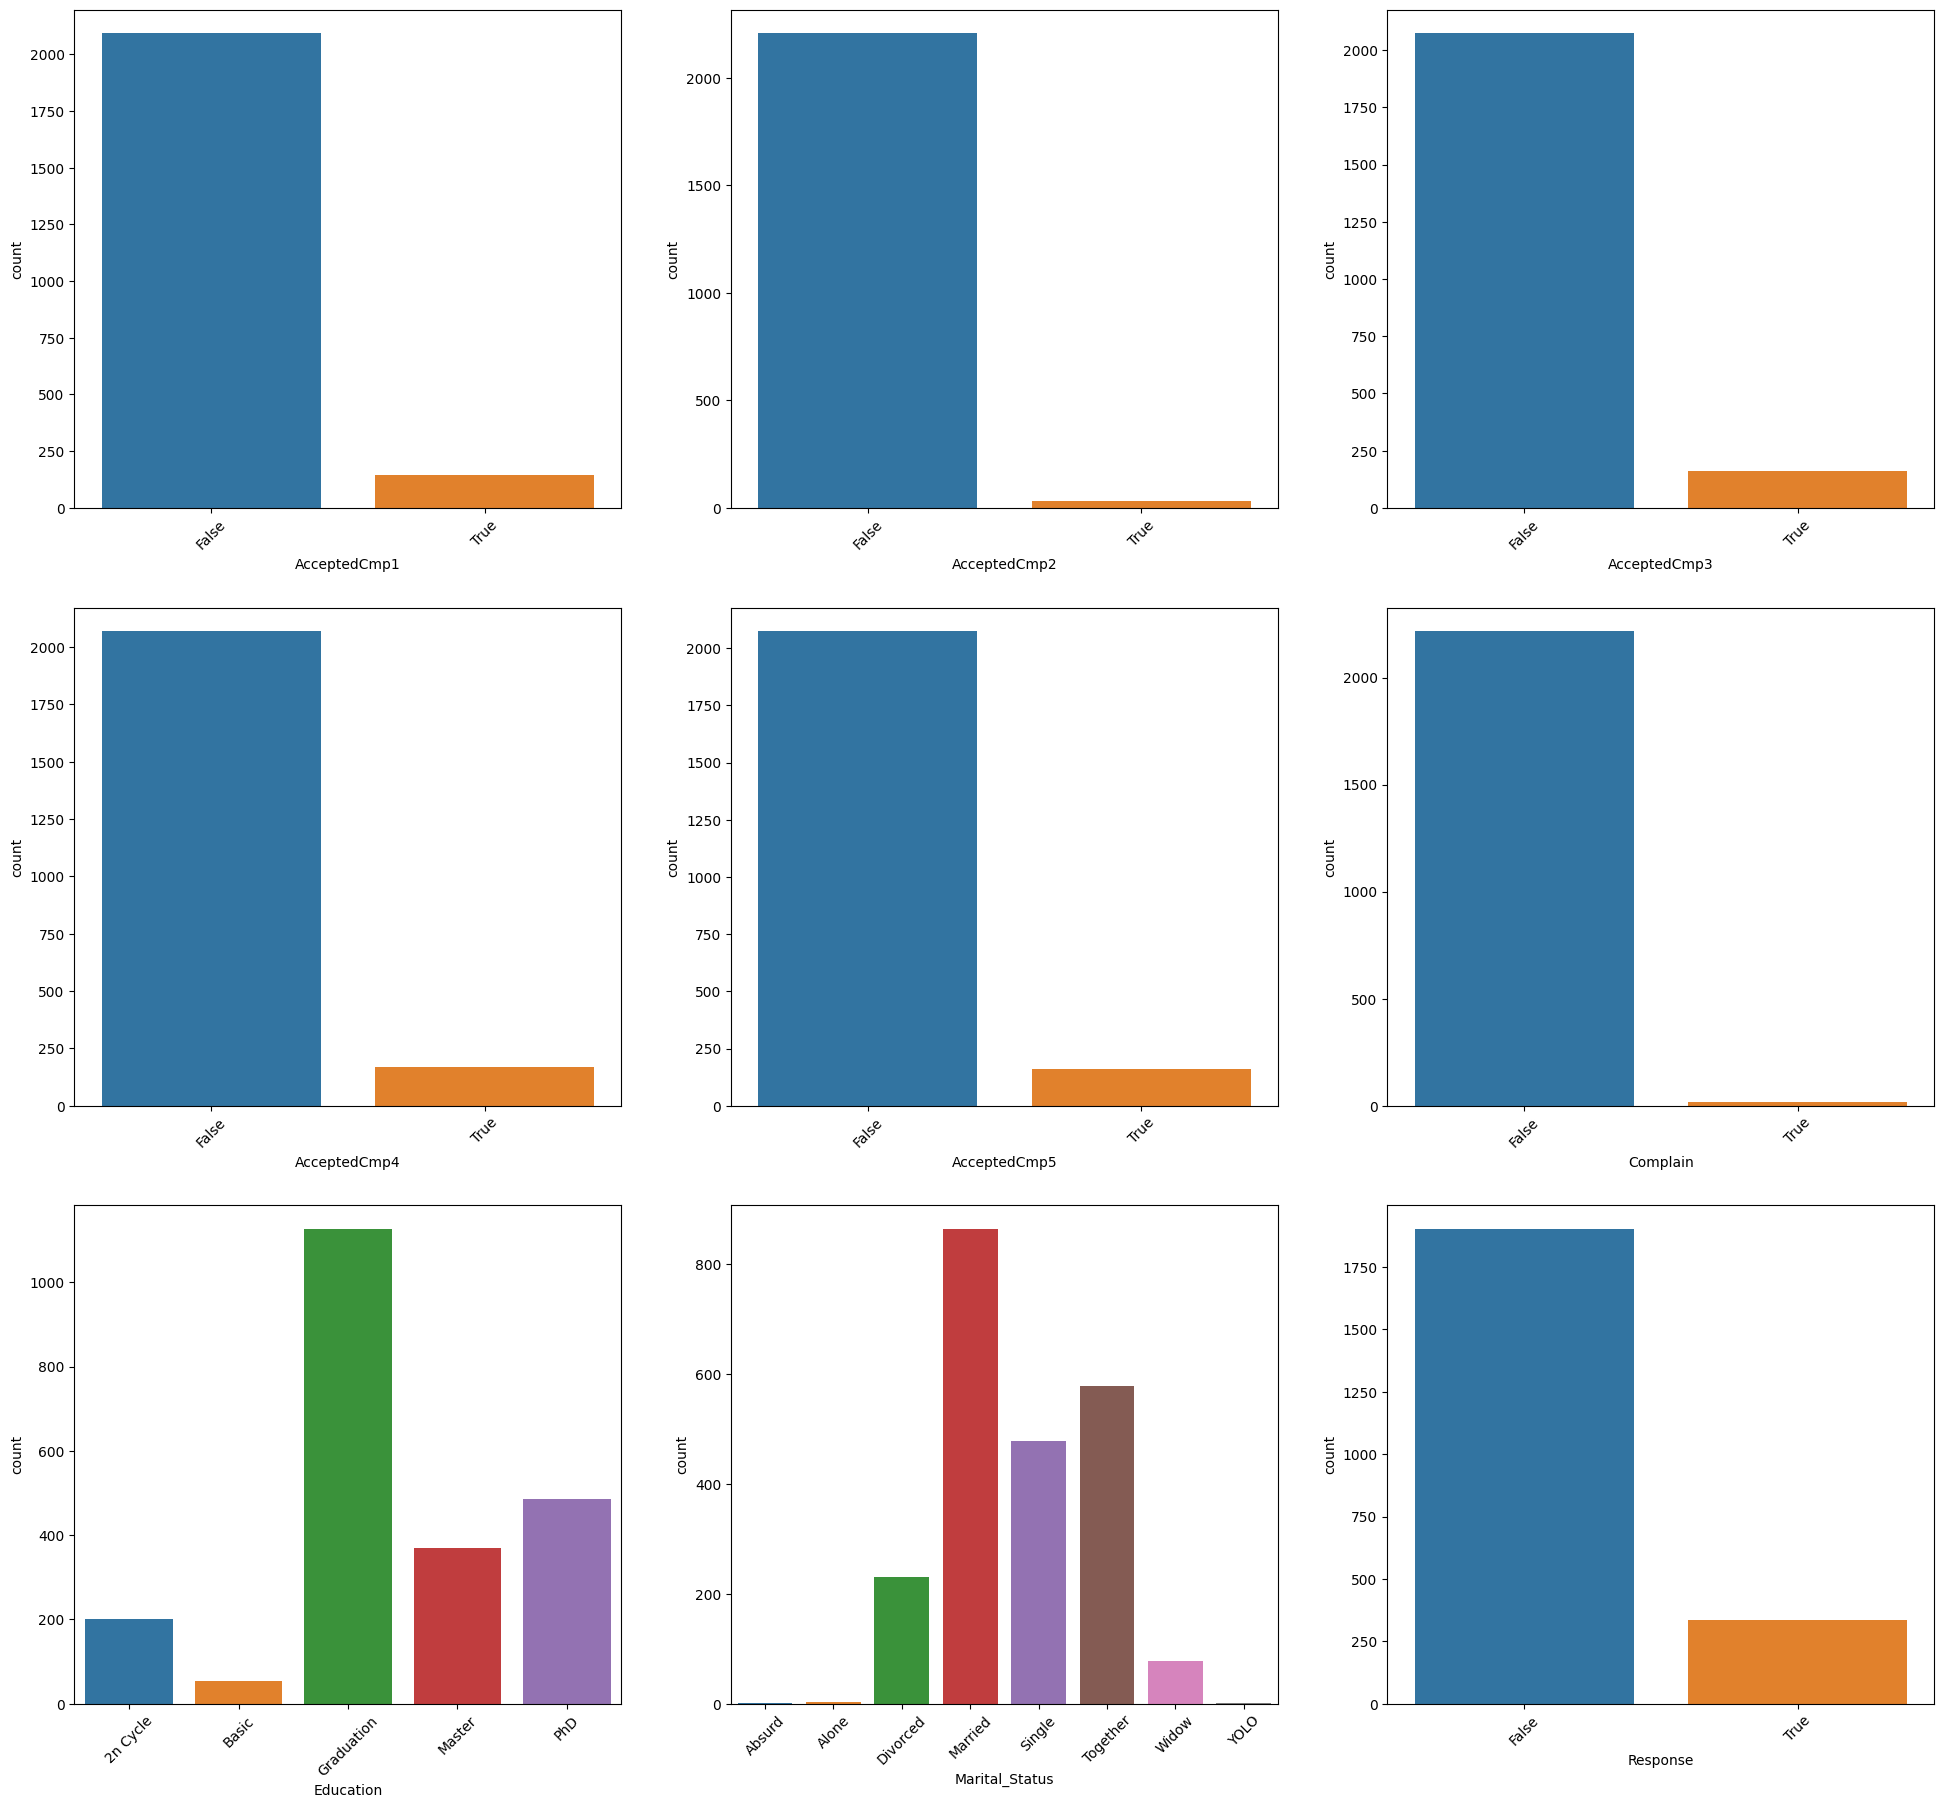

In [49]:
fig, axes = plt.subplots(3,3,figsize=(24,22))
for i,k in enumerate(sorted(var_qual)):
    nrow, ncol = i//3, i%3
    ax = sns.countplot(data = df,x = k,
            ax=axes[nrow,ncol])
    ax.set_xticklabels(rotation = 45, labels = ax.get_xticklabels())

plt.show()

In [50]:
df.Education.value_counts()

Education
Graduation    1126
PhD            485
Master         370
2n Cycle       201
Basic           54
Name: count, dtype: int64

* Majorité de personne refuse les campagnes publicitaires, mais a chaque campagne nous avons quand même des adhérents
* La majorité est au moins titulaire d'un bac


In [51]:
couple = df.Marital_Status.isin(["Married","Together"]).value_counts() #récupération du décompte entre les personnes mariée et couple
couple #True signifie les personnes Married ou Together, donc le False, c'est tout le reste (les personnes seules)

Marital_Status
True     1442
False     794
Name: count, dtype: int64

In [52]:
couple.index = ["Couple","Celibataire"] #mettons les indexs 
couple

Couple         1442
Celibataire     794
Name: count, dtype: int64

In [53]:
dfcouple = pd.DataFrame(couple).T #transformation en dataframe pour faciliter la visualisation
dfcouple

Couple  Celibataire
count    1442          794

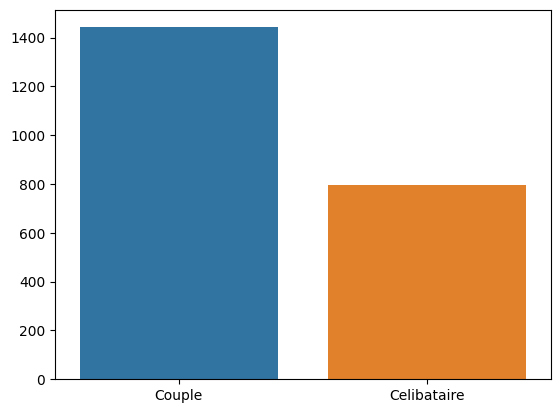

In [54]:
sns.barplot(dfcouple)
plt.show() 

- On voit ici presque 2 fois plus de personnes en couple que de célibataire


 ### Analyse bivariée

##### analyse des Variables temporelles : 
Creons un dataframe temporaire pour lequelle nous allons passer la date en index afin de faciliter les analyses

In [55]:
temp = df.copy()#dataframe temporaire qui contiendra Dt_customer en index
temp.index = temp.Dt_Customer

In [56]:
# Rééchantillonnage par mois et calcul de la moyenne
temp.Income.resample("M").mean()[:5]

Dt_Customer
2012-07-31    53680.500000
2012-08-31    50807.603305
2012-09-30    55508.383230
2012-10-31    51146.621053
2012-11-30    51485.291896
Freq: ME, Name: Income, dtype: float64

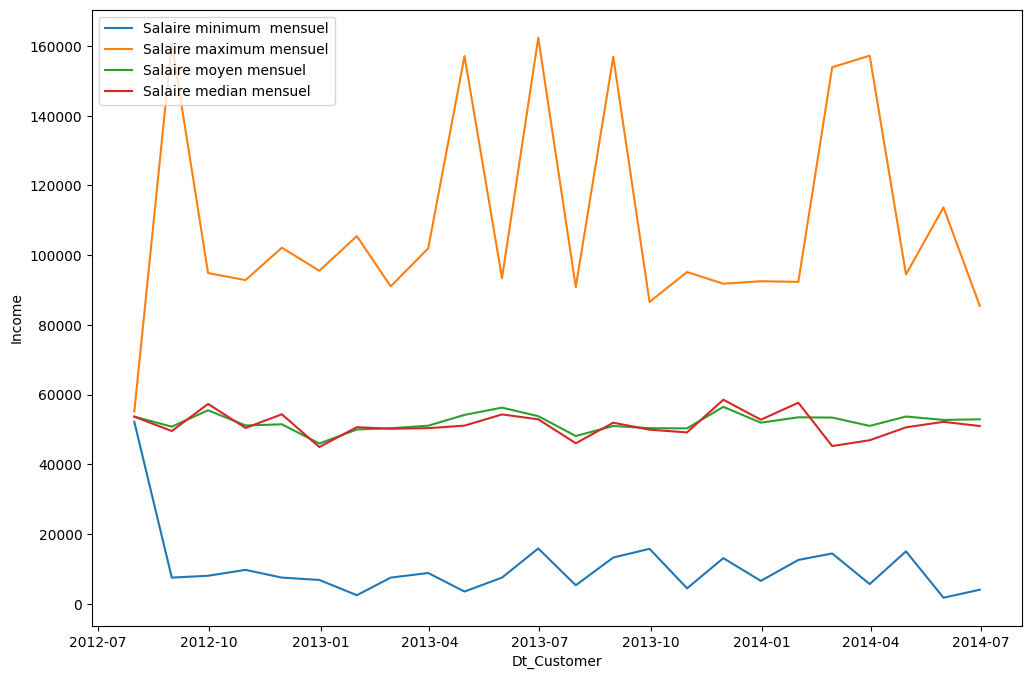

In [57]:
plt.figure(figsize=(12,8))
sns.lineplot(temp.Income.resample("M").min() , label = "Salaire minimum  mensuel")
sns.lineplot(temp.Income.resample("M").max() , label = "Salaire maximum mensuel")

sns.lineplot(temp.Income.resample("M").mean() , label = "Salaire moyen mensuel")
sns.lineplot(temp.Income.resample("M").median(), label = "Salaire median mensuel")
plt.show()

* On peut voir une belle différence entre le salaire minimum et maximum touché par mois

* **Regardons le salaire en fonction du niveau d'étude :**

<Axes: xlabel='Income', ylabel='Density'>

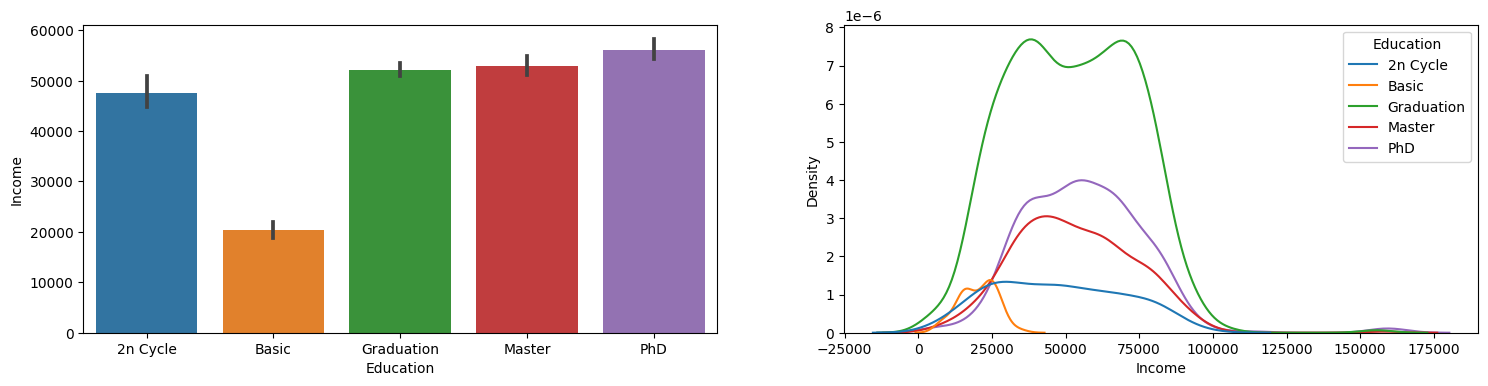

In [58]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.barplot(x="Education", y="Income", data=df)
plt.subplot(1,2,2)
sns.kdeplot(x = "Income", hue = "Education", data = df)

#### Par 2 variables continues :
- Attention ici par soucis de simplicité, je considere toutes les variables numériques comme continues

In [59]:
pd.set_option("display.max_rows",10)

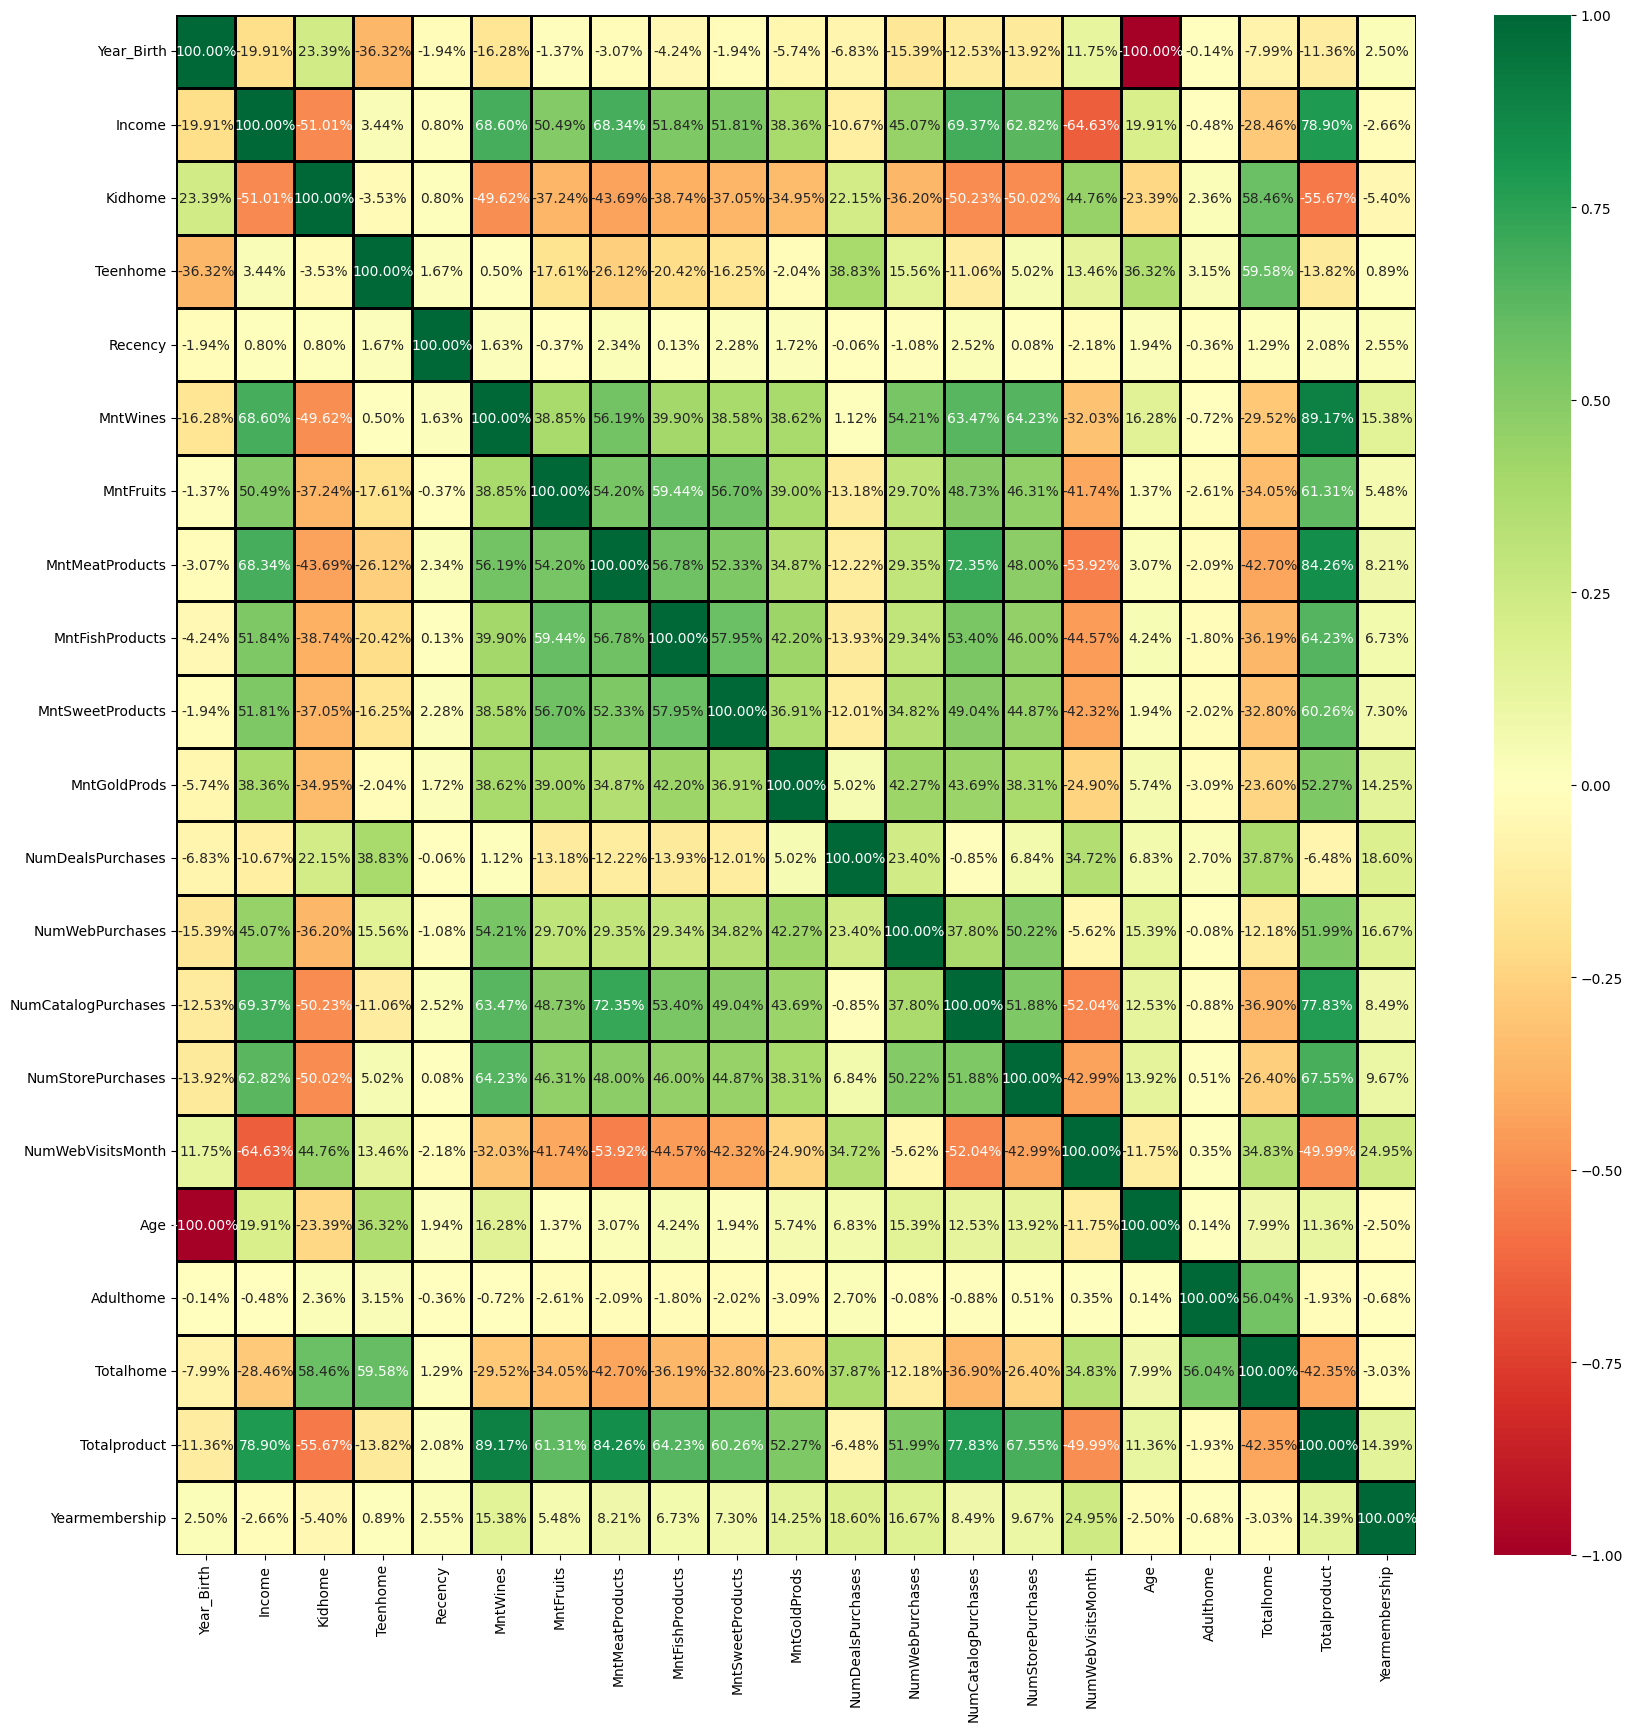

In [60]:
plt.figure(figsize=(20,20))
sns.heatmap(df[var_num].corr(), linecolor="black", linewidths=0.8, fmt = ".2%", annot = True, cmap = "RdYlGn")
plt.show()

In [61]:
# Calcul de la matrice de corrélation et multiplication par 100
corr_matrix = df[var_num].corr() * 100
# Filtrage des valeurs supérieures à 50% en valeur absolue (hors diagonale)
filtered_corr = corr_matrix[(np.abs(corr_matrix) > 50) & (np.abs(corr_matrix) < 100)]

#Récupération des lignes remplis de NaN et des colonnes remplis de NaN
rows_with_values = filtered_corr.dropna(how='all').index #suppression de toutes les colonnes qui ont QUE des NaN
cols_with_values = filtered_corr.dropna(axis=1, how='all').columns #Suppression de toutes les lignes qui ont que des NaN

#Concaténation des éléments et récupération des éléments uniques
vars_of_interest = np.unique(np.concatenate((rows_with_values, cols_with_values)))

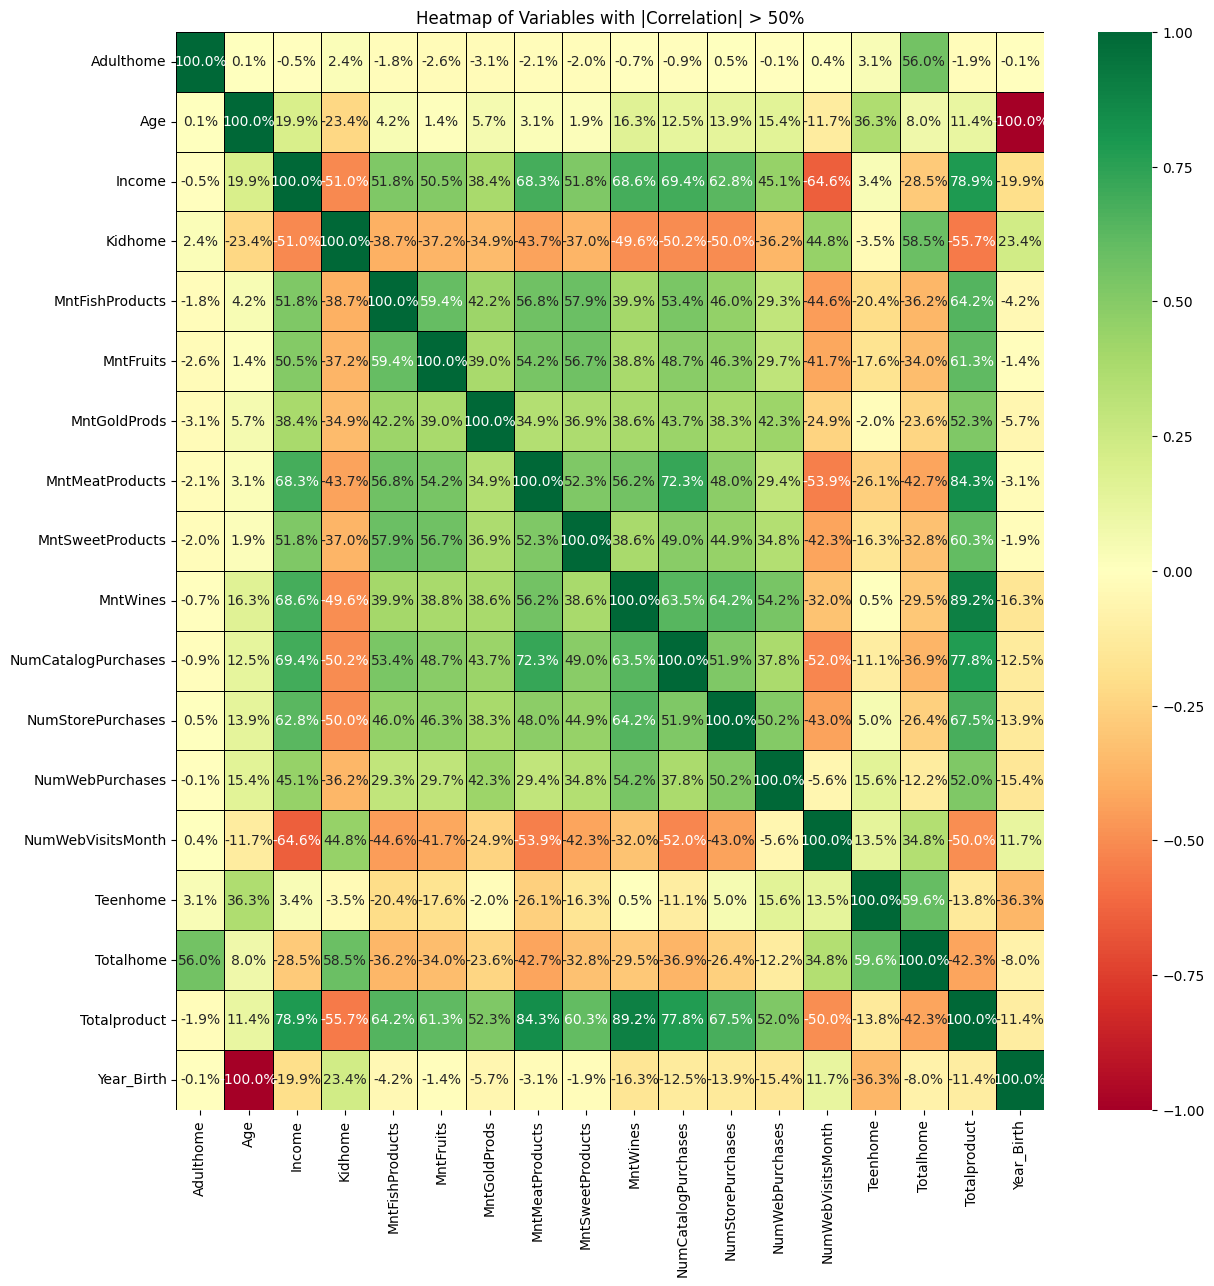

In [62]:
# Création d'une nouvelle matrice de corrélation avec ces variables
new_corr_matrix = df[vars_of_interest].corr()
# Tracé de la heatmap de la nouvelle matrice de corrélation
plt.figure(figsize=(14,14))
sns.heatmap(new_corr_matrix, annot=True, fmt=".1%", cmap='RdYlGn', linewidths = 0.7,linecolor = "black")
# Ajout d'un titre
plt.title('Heatmap of Variables with |Correlation| > 50%')
# Afficher la heatmap
plt.show()

Regardons La variable Income Vs les autres variables numérique de plus près : 

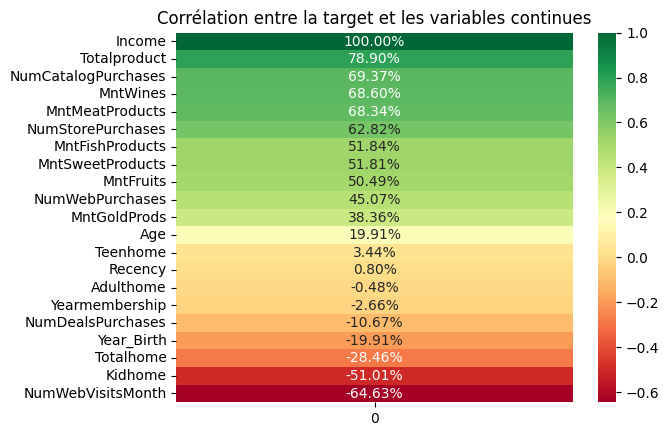

In [63]:
correlation = df[var_num].corrwith(df['Income']) #corrwith() permet de calculer la corrélation entre
# Trier les valeurs de corrélation par ordre décroissant
sorted_correlation = correlation.sort_values(ascending=False)
#la target et chaque variable continue
# plt.figure(figsize=(10, 20))
heatmap = sns.heatmap(pd.DataFrame(sorted_correlation), annot=True, cmap='RdYlGn',fmt=".2%", cbar=True)
heatmap.set_title('Corrélation entre la target et les variables continues')
plt.show()

In [64]:
correlation = df[var_num].corrwith(df['Income'])

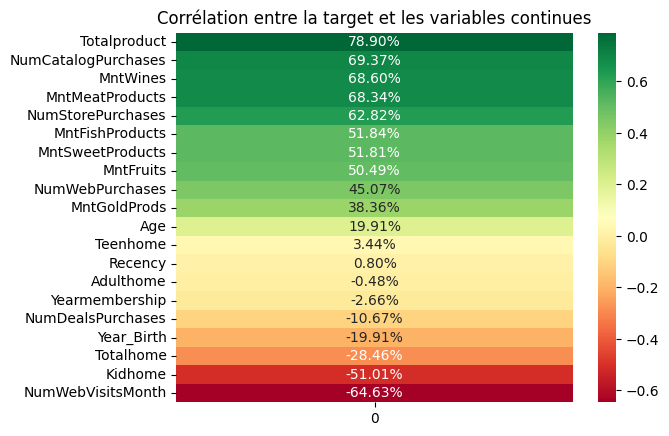

In [67]:
correlation = df[var_num].corrwith(df['Income']) #corrwith() permet de calculer la corrélation entre

correlation = correlation[np.abs(correlation)<1] #suppression de la corrélation 100% (avec elle meme)

# Trier les valeurs de corrélation par ordre décroissant
sorted_correlation = correlation.sort_values(ascending=False)
#la target et chaque variable continue
# plt.figure(figsize=(10, 20))
heatmap = sns.heatmap(pd.DataFrame(sorted_correlation), annot=True, cmap='RdYlGn',fmt=".2%", cbar=True)
heatmap.set_title('Corrélation entre la target et les variables continues')
plt.show()

#### Par 2 variables qualitatives :

In [68]:
cat_vars = df.select_dtypes(include=['int']).columns
cat_vars= cat_vars[1:]

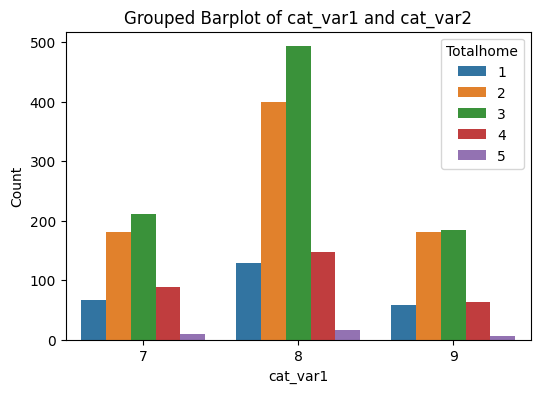

In [69]:
# Tracer un barplot groupé
plt.figure(figsize=(6,4))
sns.countplot(x=df["Yearmembership"],  hue=df["Totalhome"],data=df)
plt.title('Grouped Barplot of cat_var1 and cat_var2')
plt.xlabel('cat_var1')
plt.ylabel('Count')
plt.show()

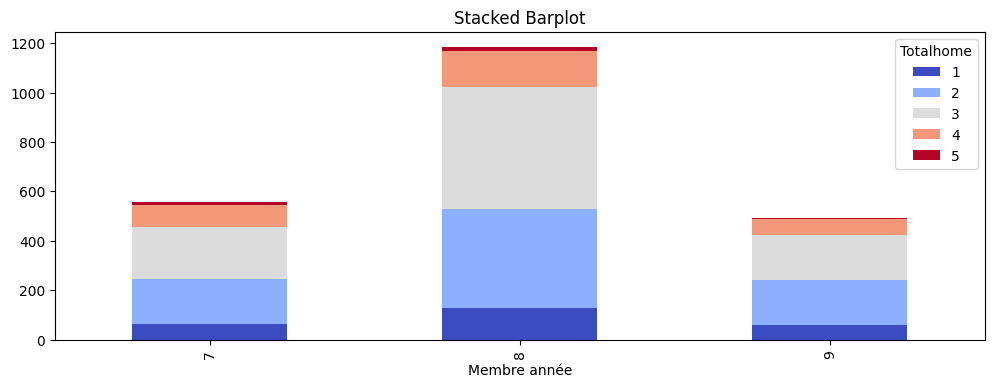

In [85]:
# Tracer un barplot empilé
contingency_table = pd.crosstab(df["Yearmembership"], df["Totalhome"])
ax = contingency_table.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,4)) 
plt.title('Stacked Barplot')
plt.xlabel("Membre année")
plt.show()


#### Variable numérique Vs catégorique

<Axes: xlabel='Income', ylabel='Totalproduct'>

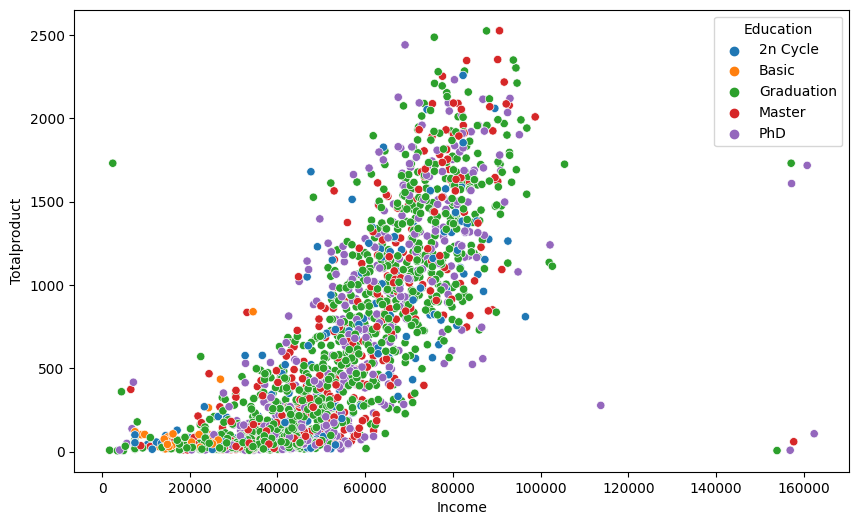

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot( y = "Totalproduct", x = "Income", hue = "Education", data =df)

## 5. PCA et clusterisation sur les variables continues
- En réalité nous avons **qu'une variable continue**, cependant, on va récupérer les variables qui prennent au moins 50 valeurs différentes et les considérer aussi comme des variables continues
### Standardisation des données 

In [117]:
for i in zip(var_num, df[var_num].nunique()):
    print(i) 
#en choisissant 50, on retire toutes les variables binaires et les variables discrètes ayant que très peu de valeurs différentes et on conserve age/year_birth

('Year_Birth', 56)
('Income', 1974)
('Kidhome', 3)
('Teenhome', 3)
('Recency', 100)
('MntWines', 775)
('MntFruits', 158)
('MntMeatProducts', 557)
('MntFishProducts', 182)
('MntSweetProducts', 177)
('MntGoldProds', 213)
('NumDealsPurchases', 15)
('NumWebPurchases', 15)
('NumCatalogPurchases', 14)
('NumStorePurchases', 14)
('NumWebVisitsMonth', 16)
('Age', 56)
('Adulthome', 2)
('Totalhome', 5)
('Totalproduct', 1054)
('Yearmembership', 3)


In [123]:
var_pca = list(df[var_num].nunique()[df[var_num].nunique()>50].index)
var_pca

['Year_Birth',
 'Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'Age',
 'Totalproduct']

**Standardisation des données**

In [132]:
#Séparation en train et test set :
X = df[var_pca]
X_train,X_test = train_test_split(X, random_state = 42, )
print('shape X_train, X_test :\n', X_train.shape,X_test.shape)

shape X_train, X_test :
 (1677, 11) (559, 11)


In [134]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [147]:
X_reduced = pd.DataFrame(scaler.transform(X), columns = X.columns)

In [140]:
pca = PCA(n_components=0.90)
x_pca = pca.fit_transform(X_scaled)

In [150]:
#Transformons les données pca directement en un dataframe
#ou les colonnes sont les components principales 
#et les lignes les individus 
df_x_pca = pd.DataFrame(x_pca, columns=[f"F{i+1}" for i in range(pca.n_components_)],index=X_reduced.index)
df_x_pca.head()

F1        F2        F3        F4        F5        F6
0  4.009874 -0.701081 -0.211258 -1.226240 -0.351408 -0.350988
1 -1.719094 -1.952298  0.433694 -0.299164 -0.347023 -0.013631
2  1.143986 -0.353230  0.881869 -0.277130 -0.216406 -0.504812
3 -2.326313  1.632618  0.741132  0.005690 -0.166742 -0.041618
4 -0.329592  1.392713 -1.557564 -0.190430 -0.586010 -0.245113

In [151]:
#Recuperons les indices des principals components
n_components = [i for i in range(pca.n_components_)]

In [152]:
#Récupération de la variance (autrement dit l'information conservée au travers chaque components principales)

#Calcul de la variance cumulée en %
sse = pca.explained_variance_ratio_*100
#Calcul de la somme cumulée de chaque variance :
sse_cum = [round(i,2) for i in np.cumsum(sse)]
sse_cum

[44.87, 62.82, 72.1, 79.94, 86.33, 90.36]

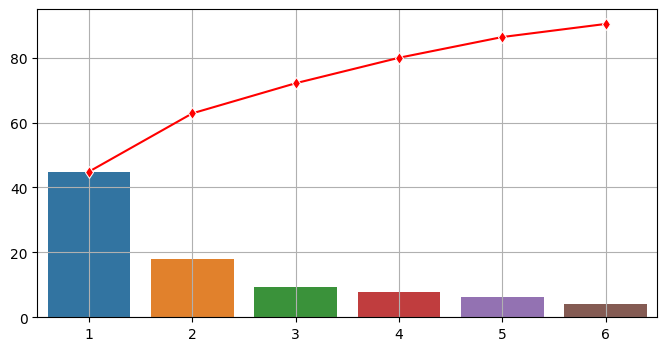

In [153]:
### Regardons graphiquement ce que chaque composantes principale apporte comme information
plt.figure(figsize=(8,4))
sns.lineplot(x = n_components, y=sse_cum, markers="d", color = "red",style=True)
ax = sns.barplot(x = n_components, y=sse,)
ax.get_legend().remove()#suppression de la legende pour le markers du lineplot
ax.set_xticklabels([i+1 for i in n_components])#pour commencer a compter à partir de 1 sur le graph
plt.grid()



In [154]:
print(f"On passe de {pca.n_features_} à {pca.n_components_} features")
print(f"soit une réduction de {pca.n_features_-pca.n_components_} variables ")
print(f"Nous perdons {round((100-sse_cum[-1]))} % d'informations")

On passe de 11 à 6 features
soit une réduction de 5 variables 
Nous perdons 10 % d'informations


In [155]:
df_pcs = pd.DataFrame(data = pca.components_, 
                   columns=X_reduced.columns,
                  index = [f"F{i+1}" for i in range(pca.n_components_)]
                  )
                  
df_pcs.head()

Year_Birth    Income   Recency  MntWines  MntFruits  MntMeatProducts  \
F1   -0.077072  0.374058  0.010477  0.346961   0.334105         0.378861   
F2    0.688649 -0.066685 -0.024254 -0.065489   0.117953         0.083534   
F3   -0.020374  0.011961 -0.998150 -0.009518   0.036996        -0.014690   
F4    0.118709  0.250934 -0.031423  0.539521  -0.418028         0.181723   
F5    0.026467 -0.114822 -0.018594  0.121977  -0.157085        -0.251381   

    MntFishProducts  MntSweetProducts  MntGoldProds       Age  Totalproduct  
F1         0.335524          0.323798      0.258680  0.077072      0.433831  
F2         0.091349          0.106457      0.034833 -0.688649      0.020475  
F3         0.027014         -0.008954     -0.013401  0.020374     -0.007717  
F4        -0.383972         -0.389612     -0.199121 -0.118709      0.264814  
F5        -0.082887         -0.204424      0.912730 -0.026467      0.024254

In [156]:
#inversons le dataframe pour faciliter la lisibilité: 
df_pcs = df_pcs.T
df_pcs.head()

F1        F2        F3        F4        F5        F6
Year_Birth -0.077072  0.688649 -0.020374  0.118709  0.026467  0.013552
Income      0.374058 -0.066685  0.011961  0.250934 -0.114822  0.076395
Recency     0.010477 -0.024254 -0.998150 -0.031423 -0.018594 -0.029286
MntWines    0.346961 -0.065489 -0.009518  0.539521  0.121977  0.074933
MntFruits   0.334105  0.117953  0.036996 -0.418028 -0.157085 -0.544019

In [160]:
df_pcs.T

Year_Birth    Income   Recency  MntWines  MntFruits  MntMeatProducts  \
F1   -0.077072  0.374058  0.010477  0.346961   0.334105         0.378861   
F2    0.688649 -0.066685 -0.024254 -0.065489   0.117953         0.083534   
F3   -0.020374  0.011961 -0.998150 -0.009518   0.036996        -0.014690   
F4    0.118709  0.250934 -0.031423  0.539521  -0.418028         0.181723   
F5    0.026467 -0.114822 -0.018594  0.121977  -0.157085        -0.251381   
F6    0.013552  0.076395 -0.029286  0.074933  -0.544019        -0.185436   

    MntFishProducts  MntSweetProducts  MntGoldProds       Age  Totalproduct  
F1         0.335524          0.323798      0.258680  0.077072      0.433831  
F2         0.091349          0.106457      0.034833 -0.688649      0.020475  
F3         0.027014         -0.008954     -0.013401  0.020374     -0.007717  
F4        -0.383972         -0.389612     -0.199121 -0.118709      0.264814  
F5        -0.082887         -0.204424      0.912730 -0.026467      0.024254  
F6        -0.158594          0.794427      0.017574 -0.013552     -0.020130

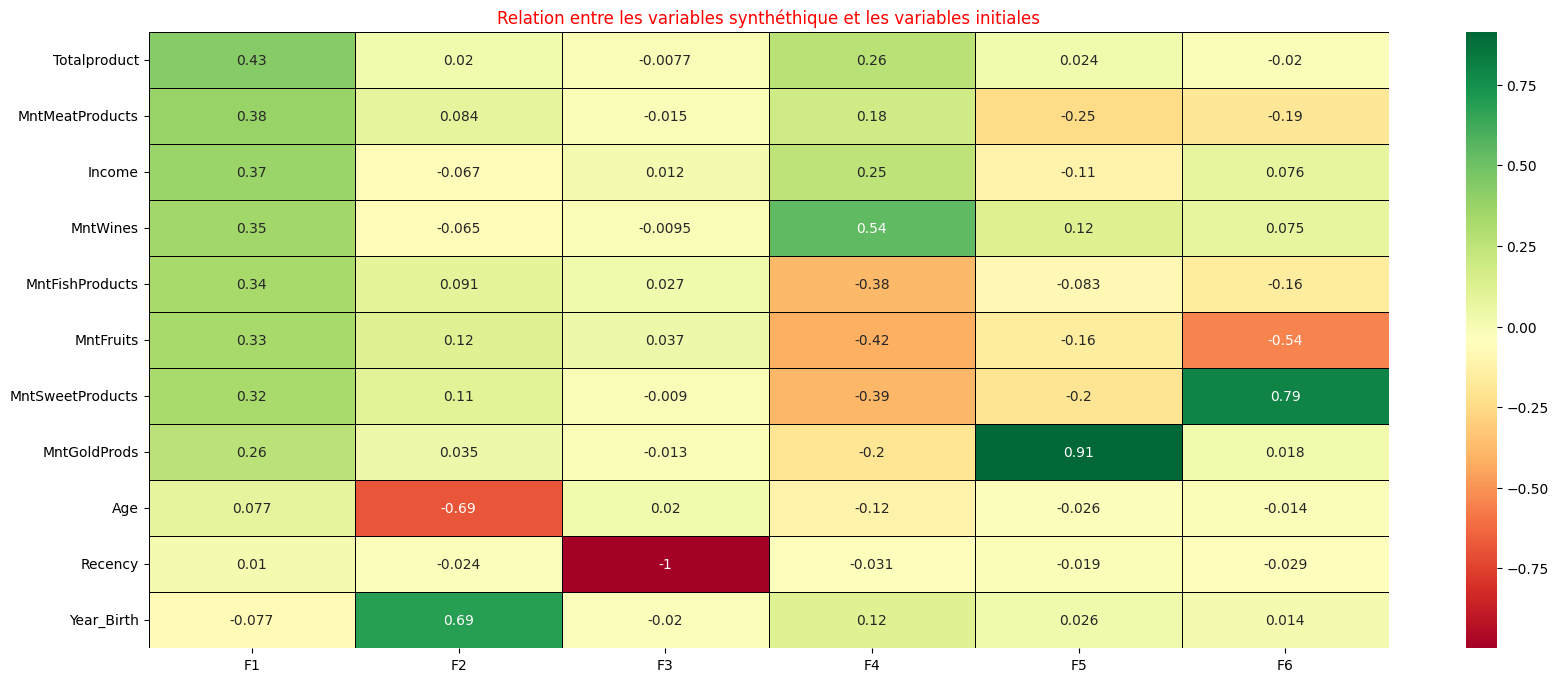

In [163]:
#Affichons une heatmap pour améliorer le confort de lecture : 

plt.figure(figsize=(20,8))
plt.title("Relation entre les variables synthéthique et les variables initiales",fontdict={"color":"red"})
sns.heatmap(df_pcs.sort_values(by="F1", ascending=False), annot = True, linecolor="black", linewidths=0.5, cmap="RdYlGn")
plt.show()

In [164]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations
    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """
    # Extrait x et y 
    x,y=x_y
    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))
    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):
        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )
        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])      
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))
   
    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

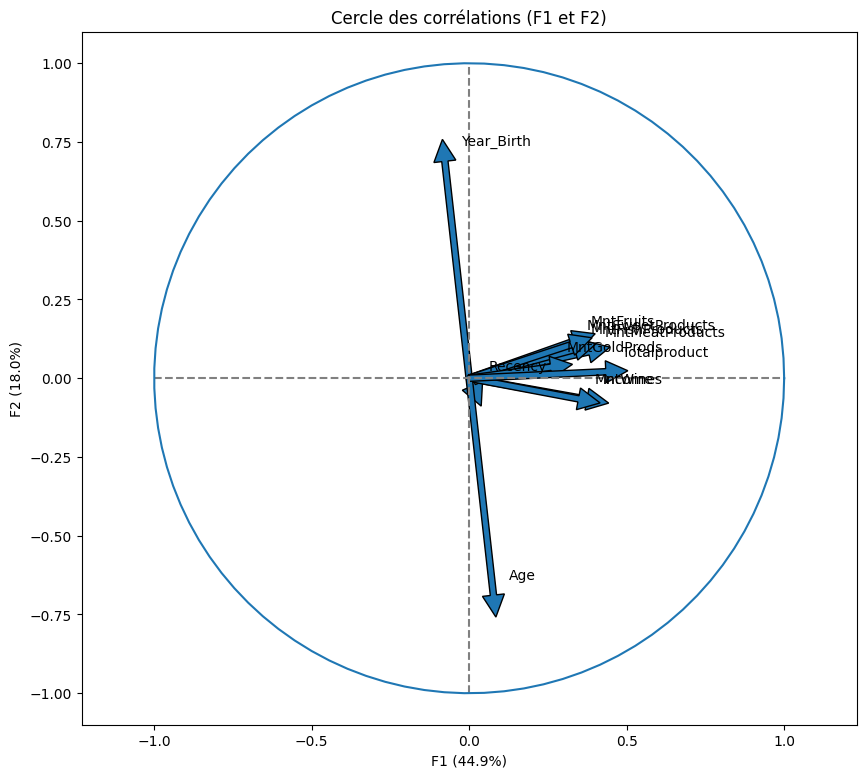

In [166]:
correlation_graph(pca, (0,1), var_pca)

- F1 est surtout corrélé au produit/achats
- F2 à l'age des individus


# Clusterisation : 
Regroupement avec K-Means |¶
- Comment regrouper des données ?
    - Le regroupement est une technique utilisée dans l'exploration de données et l'apprentissage automatique pour regrouper des points de données similaires. Il existe plusieurs algorithmes de regroupement, mais l'une des méthodes les plus populaires est le regroupement par K-Means.

- Pourquoi les K-means peuvent-elles regrouper des données ?
    - K-means est l'un des algorithmes de regroupement les plus populaires en raison de sa simplicité et de son efficacité. Son fonctionnement repose sur les principes suivants :

- Comment sélectionner le nombre de grappes dans l'algorithme K-means ?
    - La sélection du nombre optimal de grappes, souvent désigné par « K », est une étape cruciale du regroupement K-Means. Plusieurs méthodes peuvent être utilisées à cette fin, l'une des plus courantes étant la méthode Elbow. Dans la méthode Elbow, la somme des carrés à l'intérieur d'un cluster (WCSS) est tracée en fonction du nombre de clusters. Le « point de coude » représente le nombre optimal de grappes, où l'ajout de grappes supplémentaires ne réduit pas de manière significative la somme des carrés à l'intérieur des grappes (WCSS).

- Sélection du nombre de grappes de Kmeans
    - Identifier le point d'inflexion : Examinez le graphique. Le point où le taux de diminution du WCSS ralentit (formant un « coude ») est souvent une bonne indication du nombre approprié de grappes. En effet, l'ajout de grappes au-delà de ce point peut ne pas réduire de manière significative le WCSS.

Traduit avec DeepL.com (version gratuite)


In [167]:
def Kmeans_elbow(data, nclust):
    plt.figure(figsize=(8,4))
    visualizer = KElbowVisualizer(KMeans(), k=(1, nclust))  # Spécifiez la plage de k que vous souhaitez explorer
    visualizer.fit(data)
    visualizer.show()

In [169]:
from yellowbrick.cluster import KElbowVisualizer


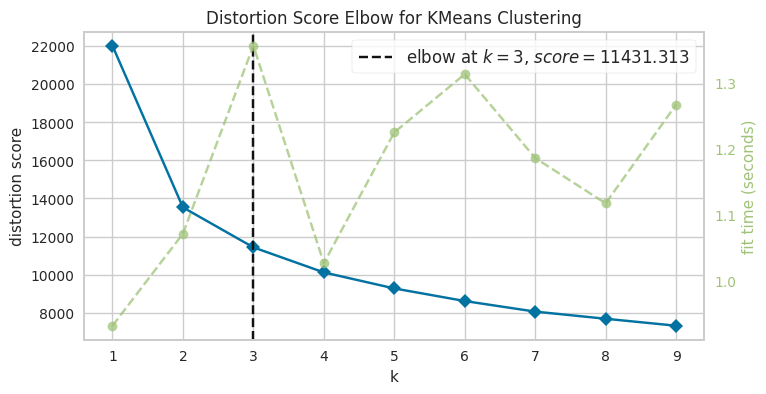

In [170]:
Kmeans_elbow(df_x_pca, 10)

- 3 semble etre le nombre de cluster idéal 

In [182]:
def graph_kmeans(data, cluster,x,y):
    kmeans = KMeans(n_clusters=cluster, random_state=42)  
    kmeans.fit(data)  

# labels de cluster attribués à chaque point de données
    labels = kmeans.labels_

#attribuons un nom pour les labels de la sur graphique : 
    lab_graph = [F"Cluster {i}" for i in labels]
    plt.title(f"Données colorisées après un kmeans à {cluster} clusters")
    sns.scatterplot(x=data.iloc[:, x], y=data.iloc[:, y],
                hue=lab_graph, #hue pour donner le nom des clusters
                hue_order=np.unique(lab_graph), #l'ordre dans lequel on veut afficher les noms grâce à la légende
                palette="bright"
                   )
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel(f"F{x+1}")
    plt.ylabel(f"F{y+1}")
    plt.show()


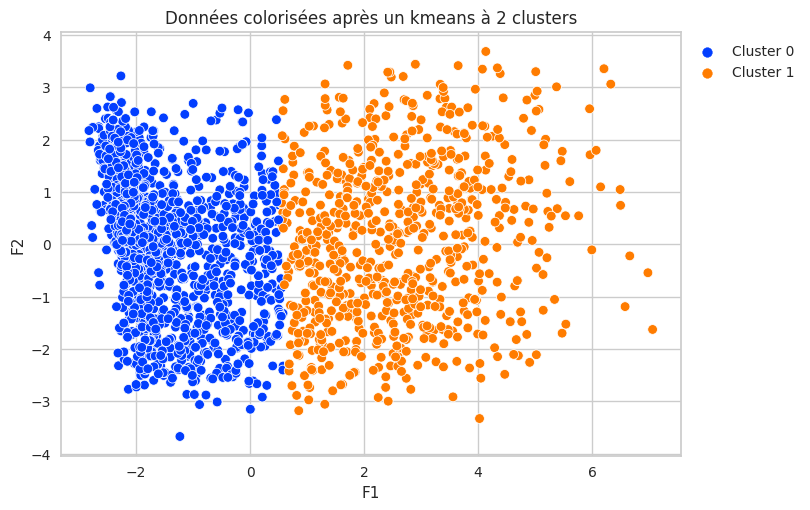

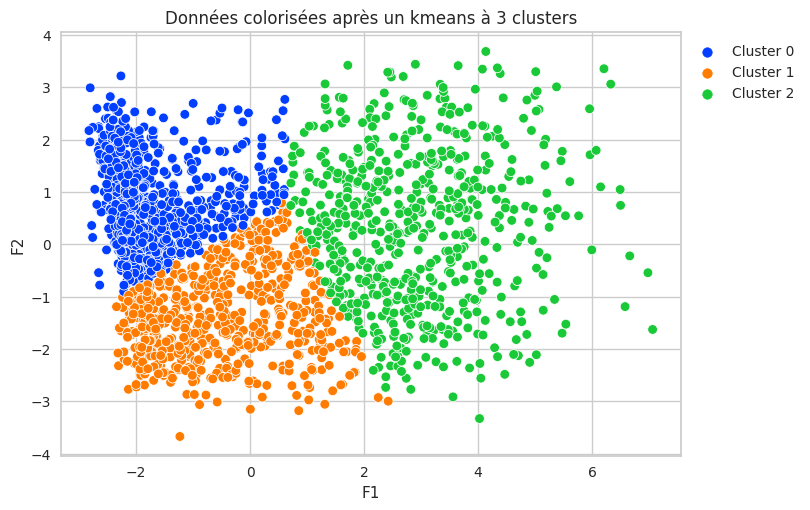

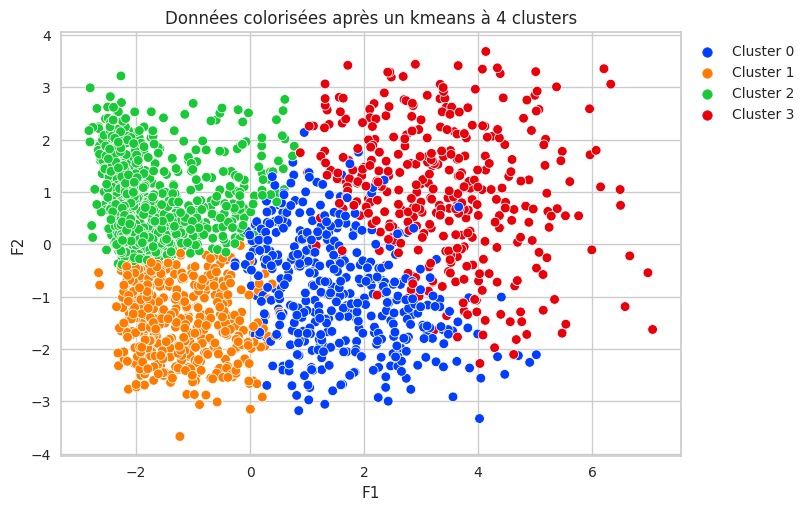

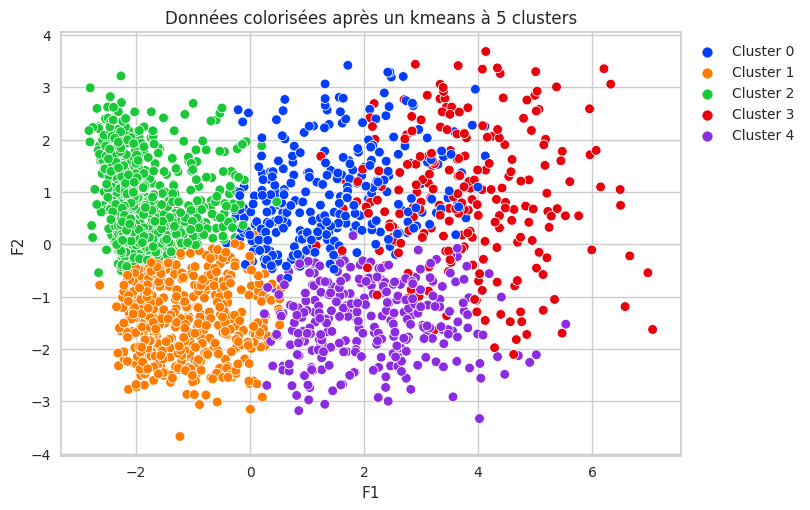

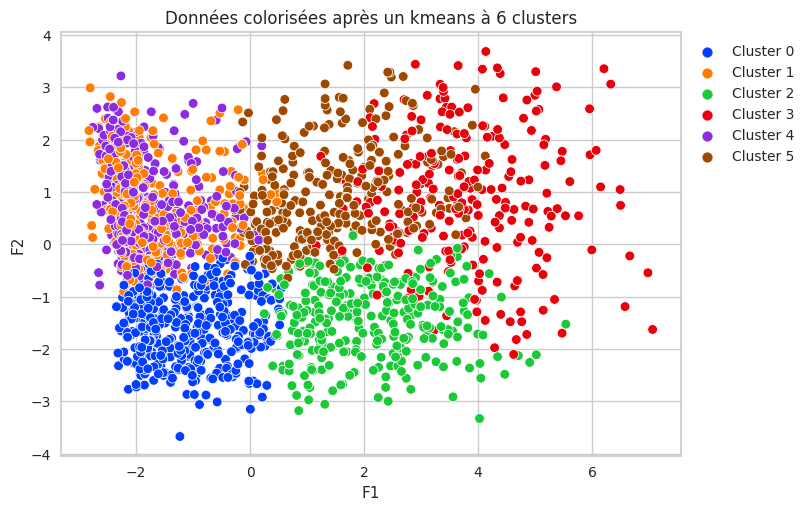

In [184]:
for i in range(2,7):
    graph_kmeans(data=df_x_pca, cluster=i,x=0,y=1)

In [194]:
kmeans = KMeans(n_clusters=3, random_state=42)  
kmeans.fit(df_x_pca)  
# labels de cluster attribués à chaque point de données
labels = kmeans.labels_
#Rajout de la colonne cluster dans le jeu de donnée non réduit :
df["Cluster"] = labels

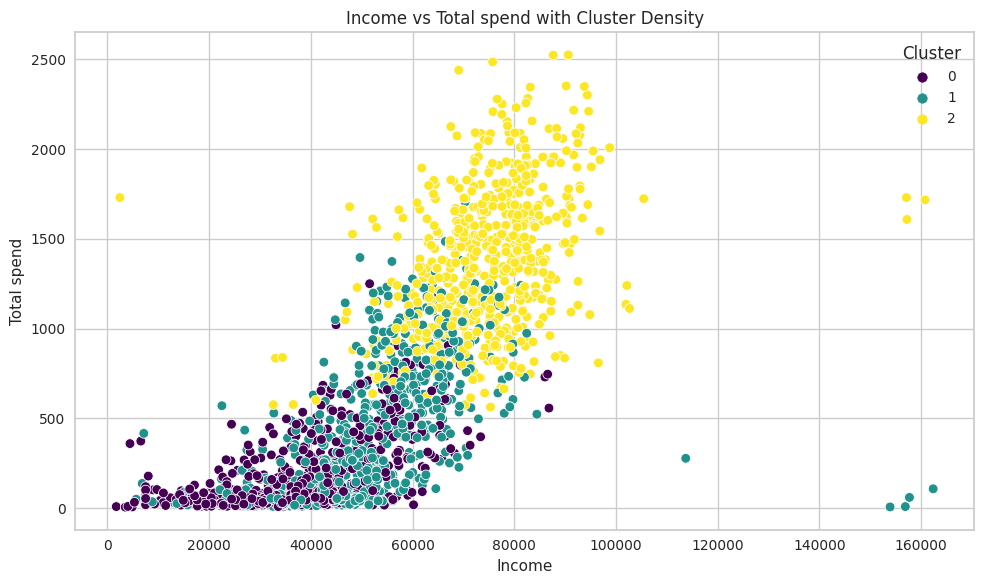

In [200]:

plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='Income', y='Totalproduct', hue='Cluster', palette="viridis", alpha=1)
#     sns.kdeplot(data=data_new, x='Income', y=col, hue='Cluster', palette=palette, alpha=.9, linewidths=1)
plt.title(f'Income vs Total spend with Cluster Density')
plt.xlabel('Income')
plt.ylabel('Total spend')

plt.tight_layout()
plt.show()
     

* Cluster 0 (Purple) : :Encompasses customers with moderate incomes and moderate to high total spending. This cluster is tightly packed, indicating a strong correlation between income and spending for this group.

* Cluster 1 (Teal): Contains customers with high incomes and high total spending. It appears to be smaller and more spread out than the other two clusters, suggesting these are premium customers who vary more in their spending despite high incomes.

* Cluster 2 (Yellow ) : : Represents customers with a wide range of incomes but generally lower total spending. This is the largest cluster and suggests a group of customers who are conservative spenders across different income levels.